In [12]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.plotting import imshow, random_colors
from mesostat.utils.pandas_helper import merge_df_from_dict
from mesostat.metric.sequence import avg_bivariate_binary_orderability_from_temporal_mean, bivariate_orderability_from_temporal_mean
from mesostat.stat.machinelearning import binary_classifier
from mesostat.stat.connectomics import offdiag_1D
from mesostat.stat.permtests import perm_test, difference_test
from mesostat.stat.resampling import sample


from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity
from src.lib.clustering import cluster_dist_matrix
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/home/alyosha/Desktop/maria/dff/'
# params['root_path_deconv'] = '/home/alyosha/Desktop/maria/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
significantCellsSelectorDatatype = {}

for datatype in ['raw', 'deconv']:
    signCellsMaintenance = SignificantCells('significant_cells_'+datatype+'_mt.h5').get_cells_by_mouse()
    signCellsReward = SignificantCells('significant_cells_'+datatype+'_enc_reward.h5').get_cells_by_mouse()

    significantCellsSelectorDatatype[datatype] = {
        'None' : None,
        'Maintenance' : signCellsMaintenance,
        'Reward' : signCellsReward
    }

# Q1: Do temporal features predict modality

Predictors:
* mean by cell, variance of mean by cell
* temporal_order by cell -> (cell-wise test, proxy via tsne)
* legendre basis by cell -> (cell-wise base wise test, proxy via tsne)
* var(temp_order) by trial by cell -> (cell-wise test, proxy via tsne)
* var(legendre_basis) by trial by cell -> (cell-wise test, proxy via tsne)
* binary_orderability
    - permutation test on directly on ABO
    - (maybe) significance matrix for each link, test counting (prob. via permutation test)
* sequencability -> proxy via tsne (count if cell does approx 1 spike)

Variations:
* Time : [Stretched, Min-cropped]
* Cells : [All, Significantly active]

## 1.1 Temporal Mean by cell

In [21]:
def count_significant_cells(dataDB, datatype, selector, condition, metricName, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, metricName, "pr", selector, settings)]
            
        nCells = dataDB.get_nchannel(mousename, datatype)
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    rezDF = pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"])
    return rezDF

In [22]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            key = (datatype, interval, condition)
            print(key)
            
            rezDF = count_significant_cells(dataDB, datatype, {"interval" : interval}, condition, "ord_mean")
            rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition']))

('raw', 6, 'performance')
('raw', 6, 'direction')
('raw', 7, 'performance')
('raw', 7, 'direction')
('raw', 8, 'performance')
('raw', 8, 'direction')
('deconv', 6, 'performance')
('deconv', 6, 'direction')
('deconv', 7, 'performance')
('deconv', 7, 'direction')
('deconv', 8, 'performance')
('deconv', 8, 'direction')


interval  datatype    condition mouse  nCellSignificant  nCellTot  \
0       raw         6  performance  m060                 1        88   
1       raw         6  performance  m061                 1        46   
2       raw         6  performance  m065                 0        83   
3       raw         6  performance  m066                 2        47   
4       raw         6  performance  m067                 0        49   
5       raw         6  performance  m068                 0        28   
6       raw         6    direction  m060                27        88   
7       raw         6    direction  m061                 2        46   
8       raw         6    direction  m065                 8        83   
9       raw         6    direction  m066                 6        47   
10      raw         6    direction  m067                 4        49   
11      raw         6    direction  m068                 1        28   
12      raw         7  performance  m060                 0        88   
13      raw         7  performance  m061                 0        46   
14      raw         7  performance  m065                 0        83   
15      raw         7  performance  m066                 0        47   
16      raw         7  performance  m067                 1        49   
17      raw         7  performance  m068                 1        28   
18      raw         7    direction  m060                 4        88   
19      raw         7    direction  m061                 2        46   
20      raw         7    direction  m065                 7        83   
21      raw         7    direction  m066                 1        47   
22      raw         7    direction  m067                 0        49   
23      raw         7    direction  m068                 2        28   
24      raw         8  performance  m060                 3        88   
25      raw         8  performance  m061                 0        46   
26      raw         8  performance  m065                 1        83   
27      raw         8  performance  m066                 0        47   
28      raw         8  performance  m067                 1        49   
29      raw         8  performance  m068                 0        28   
30      raw         8    direction  m060                 1        88   
31      raw         8    direction  m061                 1        46   
32      raw         8    direction  m065                 7        83   
33      raw         8    direction  m066                 0        47   
34      raw         8    direction  m067                 0        49   
35      raw         8    direction  m068                 0        28   
36   deconv         6  performance  m060                 1        88   
37   deconv         6  performance  m061                 2        46   
38   deconv         6  performance  m065                 0        83   
39   deconv         6  performance  m066                 2        47   
40   deconv         6  performance  m067                 0        49   
41   deconv         6  performance  m068                 0        28   
42   deconv         6    direction  m060                23        88   
43   deconv         6    direction  m061                 0        46   
44   deconv         6    direction  m065                 8        83   
45   deconv         6    direction  m066                 1        47   
46   deconv         6    direction  m067                 3        49   
47   deconv         6    direction  m068                 0        28   
48   deconv         7  performance  m060                 3        88   
49   deconv         7  performance  m061                 0        46   
50   deconv         7  performance  m065                 3        83   
51   deconv         7  performance  m066                 0        47   
52   deconv         7  performance  m067                 0        49   
53   deconv         7  performance  m068                 1        28   
54   deconv         7    direction  m060   

## 1.2 Variance of Temporal Mean by cell

In [16]:
diff_func = lambda x,y: np.std(x) - np.std(y)

rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            key = (datatype, interval, condition)
            print(key)
            
            rezDF = count_significant_cells(dataDB, datatype, {"interval" : interval}, condition, "ord_mean", proxyFunc=diff_func, nResample=1000)
            rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition']))

('raw', 6, 'performance')
('raw', 6, 'direction')
('raw', 7, 'performance')
('raw', 7, 'direction')
('raw', 8, 'performance')
('raw', 8, 'direction')
('deconv', 6, 'performance')
('deconv', 6, 'direction')
('deconv', 7, 'performance')
('deconv', 7, 'direction')
('deconv', 8, 'performance')
('deconv', 8, 'direction')


interval  datatype    condition mouse  nCellSignificant  nCellTot  \
0       raw         6  performance  m060                 4        88   
1       raw         6  performance  m061                 2        46   
2       raw         6  performance  m065                 1        83   
3       raw         6  performance  m066                 1        47   
4       raw         6  performance  m067                 0        49   
5       raw         6  performance  m068                 2        28   
6       raw         6    direction  m060                10        88   
7       raw         6    direction  m061                 2        46   
8       raw         6    direction  m065                 6        83   
9       raw         6    direction  m066                 0        47   
10      raw         6    direction  m067                 0        49   
11      raw         6    direction  m068                 0        28   
12      raw         7  performance  m060                 4        88   
13      raw         7  performance  m061                 0        46   
14      raw         7  performance  m065                 1        83   
15      raw         7  performance  m066                 1        47   
16      raw         7  performance  m067                 3        49   
17      raw         7  performance  m068                 2        28   
18      raw         7    direction  m060                 2        88   
19      raw         7    direction  m061                 1        46   
20      raw         7    direction  m065                 4        83   
21      raw         7    direction  m066                 1        47   
22      raw         7    direction  m067                 0        49   
23      raw         7    direction  m068                 1        28   
24      raw         8  performance  m060                 2        88   
25      raw         8  performance  m061                 0        46   
26      raw         8  performance  m065                 3        83   
27      raw         8  performance  m066                 0        47   
28      raw         8  performance  m067                 0        49   
29      raw         8  performance  m068                 0        28   
30      raw         8    direction  m060                 3        88   
31      raw         8    direction  m061                 0        46   
32      raw         8    direction  m065                 5        83   
33      raw         8    direction  m066                 2        47   
34      raw         8    direction  m067                 2        49   
35      raw         8    direction  m068                 0        28   
36   deconv         6  performance  m060                 1        88   
37   deconv         6  performance  m061                 3        46   
38   deconv         6  performance  m065                 4        83   
39   deconv         6  performance  m066                 1        47   
40   deconv         6  performance  m067                 1        49   
41   deconv         6  performance  m068                 1        28   
42   deconv         6    direction  m060                11        88   
43   deconv         6    direction  m061                 2        46   
44   deconv         6    direction  m065                 7        83   
45   deconv         6    direction  m066                 1        47   
46   deconv         6    direction  m067                 1        49   
47   deconv         6    direction  m068                 1        28   
48   deconv         7  performance  m060                 3        88   
49   deconv         7  performance  m061                 2        46   
50   deconv         7  performance  m065                 0        83   
51   deconv         7  performance  m066                 1        47   
52   deconv         7  performance  m067                 0        49   
53   deconv         7  performance  m068                 0        28   
54   deconv         7    direction  m060   

## 1.3 Legendre Basis by cell

In [50]:
def count_significant_cells_legendre(dataDB, datatype, selector, condition, basisIdx, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, 'temporal_basis', "pr", selector, settings)[:,:,basisIdx]]
            
        nCells = dataDB.get_nchannel(mousename, datatype)
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    rezDF = pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"])
#     display(rezDF)
    return rezDF

In [53]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for basisIdx in [1, 2]:            
                key = (datatype, interval, condition, basisIdx)
                print(key)

                rezDF = count_significant_cells_legendre(dataDB, datatype, {"interval" : iInterv}, condition, basisIdx)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'basisIdx']))

Interval 5


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                23        88          25.3
1  m061                 3        46           2.0
2  m065                10        83           7.9
3  m066                 4        47           2.9
4  m067                 4        49           2.8
5  m068                 1        28           0.6

Interval 6


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                 3        88           1.2
1  m061                 0        46           0.0
2  m065                 6        83           3.7
3  m066                 1        47           0.4
4  m067                 1        49           0.4
5  m068                 1        28           0.6

Interval 7


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                 1        88           0.2
1  m061                 2        46           1.1
2  m065                 5        83           2.8
3  m066                 0        47          -0.0
4  m067                 0        49           0.0
5  m068                 0        28          -0.0

### Legendre STD

In [63]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for basisIdx in [1, 2]:            
                key = (datatype, interval, condition, basisIdx)
                print(key)

                rezDF = count_significant_cells_legendre(dataDB, datatype, {"interval" : iInterv}, condition, basisIdx, proxyFunc=np.std)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'basisIdx']))

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                 0        88           0.0
1  m061                 1        46           0.4
2  m065                 0        83           0.0
3  m066                 0        47          -0.0
4  m067                 0        49           0.0
5  m068                 1        28           0.6

Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                 3        88           1.2
1  m061                 2        46           1.1
2  m065                 2        83           0.7
3  m066                 1        47           0.4
4  m067                 1        49           0.4
5  m068                 0        28          -0.0

Interval 7
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


mouse  nCellSignificant  nCellTot  -log10(pval)
0  m060                 3        88           1.2
1  m061                 1        46           0.4
2  m065                 4        83           2.0
3  m066                 3        47           1.9
4  m067                 0        49           0.0
5  m068                 1        28           0.6

# 2 Testing orderability

1. For each trial and channel, compute temporal means
2. For a set of trials, compute average binary orderability from temporal means
3. Do permutation test on modality trials

In [17]:
diff_func = lambda x, y: avg_bivariate_binary_orderability_from_temporal_mean(x) - avg_bivariate_binary_orderability_from_temporal_mean(y)

def test_orderability(dataDB, datatype, selector, condition, nResample=1000, pval=0.01, proxyFunc=None, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    settingsTest = {"haveEffectSize" : True, "haveMeans" : True}
    
    if signCellsMouseDict is not None:
        channelFilter = signCellsMouseDict
    else:
        channelFilter = None
    
    rezLst = []
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "ord_mean", "rp", selector, settings, channelFilter=channelFilter)]
            
        pLess, pMore, eff, mu1, mu2 = difference_test(diff_func, means[0], means[1], nSample=1000, sampleFunction="permutation", settings=settingsTest)
        
        rezLst += [[mousename, pLess, pMore, eff, mu1, mu2]]
        
    columnNames = ['mousename', 'pValLess', 'pValMore', 'EffSize', 'diffTrue', 'diffRand']
    
    rezDF = pd.DataFrame(rezLst, columns=columnNames)
#     display(rezDF)
    return rezDF

In [20]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
                key = (datatype, interval, condition, signCellsName)
                print(key)
                
                rezDF = test_orderability(dataDB, datatype, {"interval" : interval}, condition, signCellsMouseDict=signCells)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'filter']))

('raw', 6, 'performance', 'None')
('raw', 6, 'performance', 'Maintenance')
('raw', 6, 'performance', 'Reward')
('raw', 6, 'direction', 'None')
('raw', 6, 'direction', 'Maintenance')
('raw', 6, 'direction', 'Reward')
('raw', 7, 'performance', 'None')
('raw', 7, 'performance', 'Maintenance')
('raw', 7, 'performance', 'Reward')
('raw', 7, 'direction', 'None')
('raw', 7, 'direction', 'Maintenance')
('raw', 7, 'direction', 'Reward')
('raw', 8, 'performance', 'None')
('raw', 8, 'performance', 'Maintenance')
('raw', 8, 'performance', 'Reward')
('raw', 8, 'direction', 'None')
('raw', 8, 'direction', 'Maintenance')
('raw', 8, 'direction', 'Reward')
('deconv', 6, 'performance', 'None')
('deconv', 6, 'performance', 'Maintenance')
('deconv', 6, 'performance', 'Reward')
('deconv', 6, 'direction', 'None')
('deconv', 6, 'direction', 'Maintenance')
('deconv', 6, 'direction', 'Reward')
('deconv', 7, 'performance', 'None')
('deconv', 7, 'performance', 'Maintenance')
('deconv', 7, 'performance', 'Reward'

interval  datatype    condition       filter mousename  pValLess  \
0        raw         6  performance         None      m060     0.510   
1        raw         6  performance         None      m061     0.673   
2        raw         6  performance         None      m065     0.648   
3        raw         6  performance         None      m066     0.204   
4        raw         6  performance         None      m067     0.508   
5        raw         6  performance         None      m068     0.397   
6        raw         6  performance  Maintenance      m060     0.389   
7        raw         6  performance  Maintenance      m061     0.698   
8        raw         6  performance  Maintenance      m065     0.586   
9        raw         6  performance  Maintenance      m066     0.100   
10       raw         6  performance  Maintenance      m067     0.575   
11       raw         6  performance  Maintenance      m068     0.440   
12       raw         6  performance       Reward      m060     0.095   
13       raw         6  performance       Reward      m061     0.585   
14       raw         6  performance       Reward      m065     0.759   
15       raw         6  performance       Reward      m066     0.019   
16       raw         6  performance       Reward      m067     0.483   
17       raw         6  performance       Reward      m068     0.525   
18       raw         6    direction         None      m060     1.000   
19       raw         6    direction         None      m061     0.785   
20       raw         6    direction         None      m065     0.961   
21       raw         6    direction         None      m066     0.828   
22       raw         6    direction         None      m067     0.016   
23       raw         6    direction         None      m068     0.345   
24       raw         6    direction  Maintenance      m060     1.000   
25       raw         6    direction  Maintenance      m061     0.547   
26       raw         6    direction  Maintenance      m065     0.596   
27       raw         6    direction  Maintenance      m066     0.935   
28       raw         6    direction  Maintenance      m067     0.077   
29       raw         6    direction  Maintenance      m068     0.383   
30       raw         6    direction       Reward      m060     0.993   
31       raw         6    direction       Reward      m061     0.556   
32       raw         6    direction       Reward      m065     0.521   
33       raw         6    direction       Reward      m066     0.222   
34       raw         6    direction       Reward      m067     0.183   
35       raw         6    direction       Reward      m068     0.092   
36       raw         7  performance         None      m060     0.555   
37       raw         7  performance         None      m061     0.146   
38       raw         7  performance         None      m065     0.458   
39       raw         7  performance         None      m066     0.743   
40       raw         7  performance         None      m067     0.124   
41       raw         7  performance         None      m068     0.236   
42       raw         7  performance  Maintenance      m060     0.373   
43       raw         7  performance  Maintenance      m061     0.046   
44       raw         7  performance  Maintenance      m065     0.288   
45       raw         7  performance  Maintenance      m066     0.510   
46       raw         7  performance  Maintenance      m067     0.317   
47       raw         7  performance  Maintenance      m068     0.217   
48       raw         7  performance       Reward      m060     0.510   
49       raw         7  performance       Reward      m061     0.136   
50       raw         7  performance       Reward      m065     0.469   
51       raw         7  performance       Reward      m066     0.851   
52       raw         7  performance       Reward      m067     0.691   
53       raw         7  performance       Reward      m068     0.343   
54       raw         7    direction         

# Q2: Presence of relative temporal structure in the firing pattern

Metrics:
* Temporal Mean
* Bivariate Orderability (undirected)
* Bivariate Orderability (directed)

Hypotheses:
* Neurons are more orderable than random - **True**
    * Neurons cluster by being orderable outside cluster but not inside - **True**
        * Can be explained by average timing preference - **True**
    * Exist cells that possess time-invariant orderability - **False**
        * No evidence of orderability beyond average timing
* Some neurons are useless at global orderability

TODO:
* Test if temporal mean is significantly different from 0.5
    * test mean-0.5
    * test var(mean-0.5)
    * mark cells as useful or useless
* Significance of ABO:
    - Permutation-test ABO by interval, including maintenance and retrieval
    - Filter cells, see if filtered have higher orderability

In [25]:
def mat_order_by_idx(M, idx):
    return np.copy(M[idx][:, idx])

def pairwise_subtract(data1D):
    dataExtrudeX = np.outer(np.ones(len(data1D)), data1D)
    return dataExtrudeX - dataExtrudeX.T

def get_mat_triu_elems(m):
    return m[np.triu_indices(m.shape[0])]

In [17]:
def plots_orderability(dataDB, queryDict, selector, nResample=100, signCellsMouseDict=None):    
    nMice = len(dataDB.mice)
    
    figureProp = {
        "ord"            : (4, 4, "Orderability matrices"),
        "ordSort"        : (4, 4, "Orderability matrices, sorted by max orderability"),
        "ordSort1D"      : (4, 4, "Orderability averaged for each cell"),
        "ordCorr"        : (4, 4, "Absolute Correlation between sorted orderability rows"),
        "ordCorrClust"   : (4, 4, "Absolute Correlation, sorted by clustering"),
        "ordClust"       : (4, 4, "Orderability matrices, clustered by highest correlation"),
        #"tempMeanHist"   : (4, 4, "Temporal mean histogram"),
        "avgResampledTemp": (10, 10, "Average resampled activity, colored by temporal mean"),
        "avgResampledClust": (10, 10, "Average resampled activity, colored by cluster"),
        "avgResampledClustAvg": (5, 5, "Average resampled activity, colored by cluster, cell-average")
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        dataBinOrd = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_binary",
                                        "",
                                        selector,
                                        {},
                                        channelFilter=signCellsMouseDict)
        
        dataTempMu = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_mean",
                                        "p",
                                        selector,
                                        {},
                                        channelFilter=signCellsMouseDict)
        
        # Find indices of sorted temporal order
        idxSortTempMu = np.argsort(dataTempMu)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Correlation matrix of cells
        dataBinOrdSortedZero = np.copy(dataBinOrdSorted)
        np.fill_diagonal(dataBinOrdSortedZero, 0)
        dataBinOrdSortedCorr = np.abs(np.corrcoef(dataBinOrdSortedZero))

        # Clustering of correlation matrix
        clustering = cluster_dist_matrix(dataBinOrdSortedCorr, 0.5, method='affinity')
        idxClustering = np.argsort(clustering)
        clusteringSorted = clustering[idxClustering]
        
        # Orderability and correlation sorted by clustering
        dataBinOrdSortedCorrClust = mat_order_by_idx(dataBinOrdSortedCorr, idxClustering)
        dataBinOrdClust = mat_order_by_idx(dataBinOrdSorted, idxClustering)
        
        # Resampled cell activities sorted by clustering
        cellResampledActivity = metric_by_selector(dataDB,
                                                   queryDictThis,
                                                   "resample_fixed",
                                                   "p",
                                                   selector,
                                                   {"metricSettings" : {"nResamplePoint":nResample}},
                                                   channelFilter=signCellsMouseDict)
        
        cellResampledActivitySortCluster = cellResampledActivity[idxClustering]
        cellResampledActivitySortTemporal = cellResampledActivity[idxSortTempMu]
        
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[0, 1])

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[0, 1])
        
        figs["ordSort1D"][1][iMouse].plot(meanBinOrd1D[idxSortBinOrd])
        
        imshow(*getfigs("ordCorr"), dataBinOrdSortedCorr, title=mousename, haveColorBar=True, limits=[0, 1])
        
        imshow(*getfigs("ordCorrClust"), dataBinOrdSortedCorrClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordCorrClust"][1][iMouse], clustering)
        
        imshow(*getfigs("ordClust"), dataBinOrdClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordClust"][1][iMouse], clustering)
        
        imshow(*getfigs("avgResampledTemp"), cellResampledActivitySortTemporal, title=mousename, haveColorBar=True)
        
        imshow(*getfigs("avgResampledClust"), cellResampledActivitySortCluster, title=mousename, haveColorBar=True)
        plots_lib.clustering_imshow_overplot_lines(figs["avgResampledClust"][1][iMouse], clustering, haveV=False)
  
        xResample = np.arange(nResample)
        for cluster in set(clustering):
            thisClusterData = cellResampledActivity[np.array(clustering) == cluster]
            muTrace = np.mean(thisClusterData, axis=0)
            stdTrace = np.std(thisClusterData, axis=0)
            figs["avgResampledClustAvg"][1][iMouse].plot(xResample, muTrace, label=cluster)
            figs["avgResampledClustAvg"][1][iMouse].fill_between(xResample, muTrace-stdTrace, muTrace+stdTrace, alpha=0.3)
            
        figs["avgResampledClustAvg"][1][iMouse].legend()

#         nCluster = len(set(clustering))
#         colors = random_colors(nCluster)
#         for iCell, cellAct in enumerate(cellResampledActivity):
#             thisColor = colors[clusteringSorted[iCell]]
#             figs["avgResampledAct"][1][iMouse].plot(cellAct + iCell, color=thisColor)

    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig(key + '.pdf')

Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
CPU times: user 4min 48s, sys: 4min 3s, total: 8min 51s
Wall time: 1min 16s


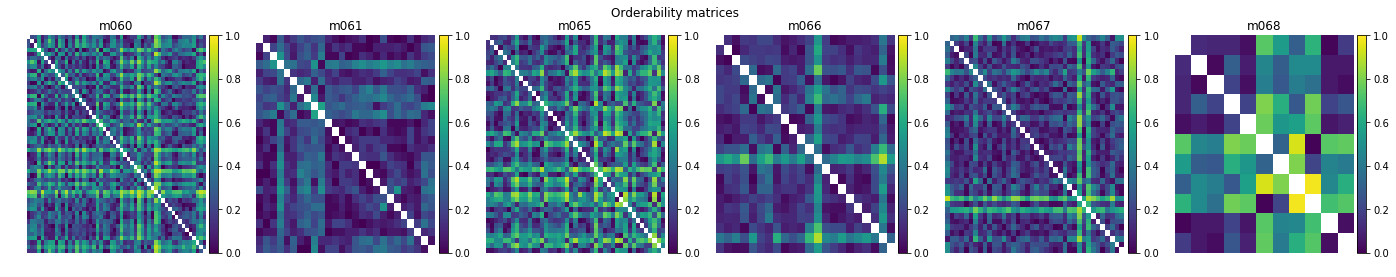

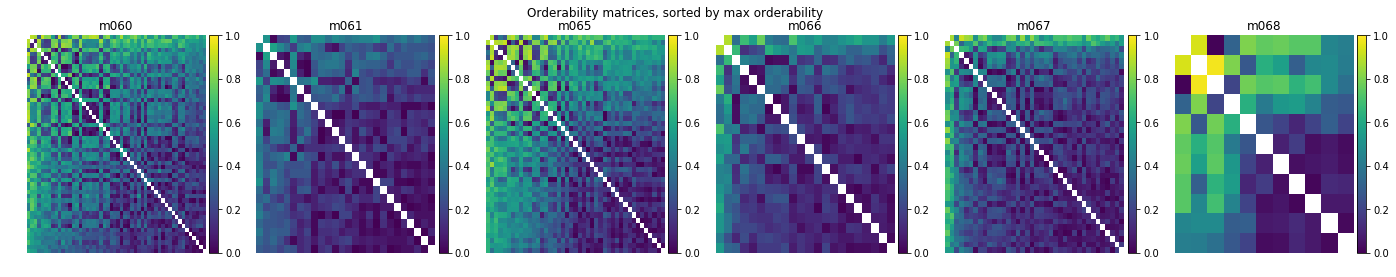

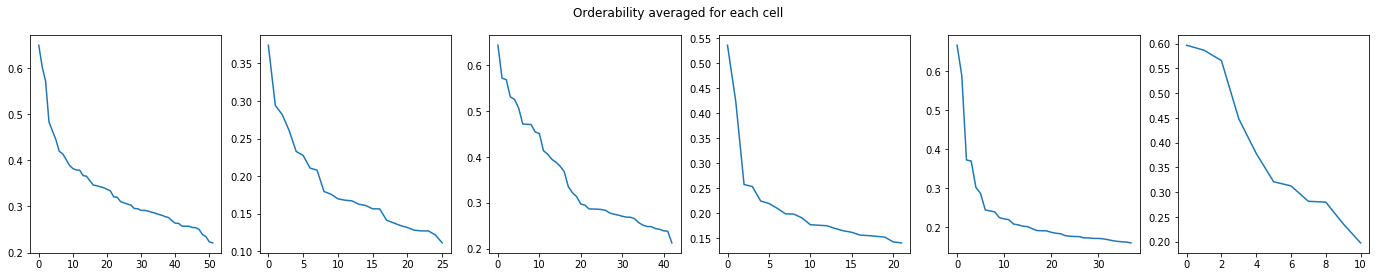

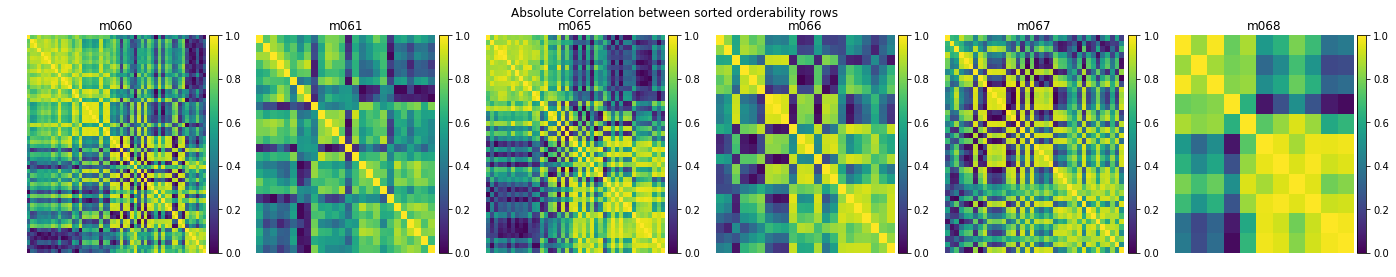

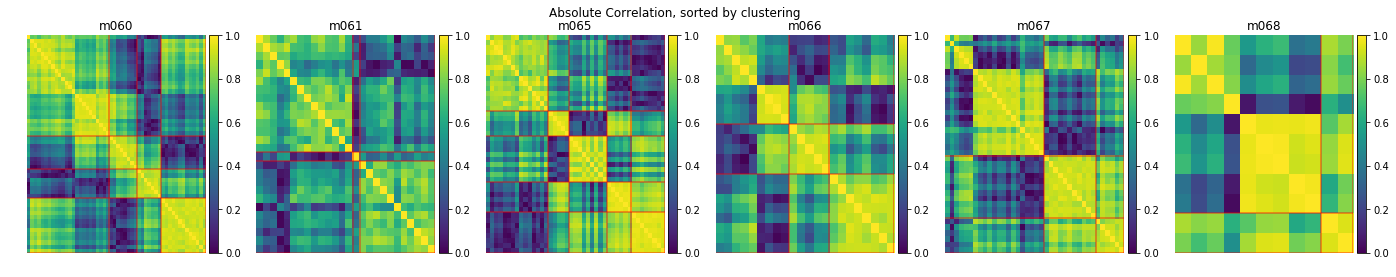

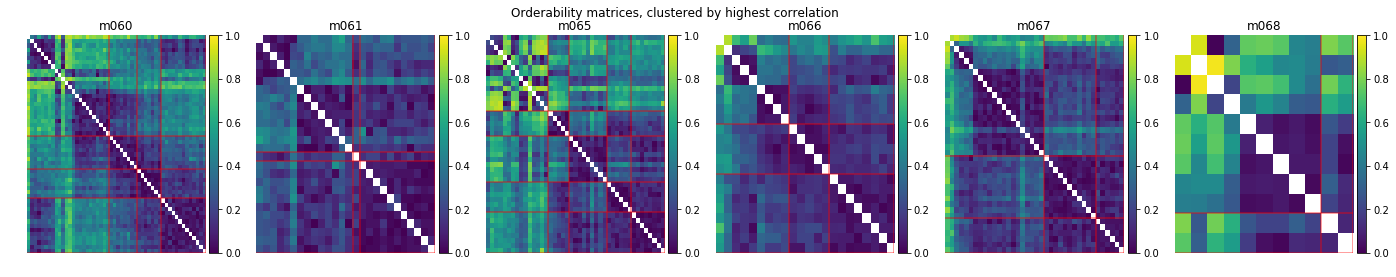

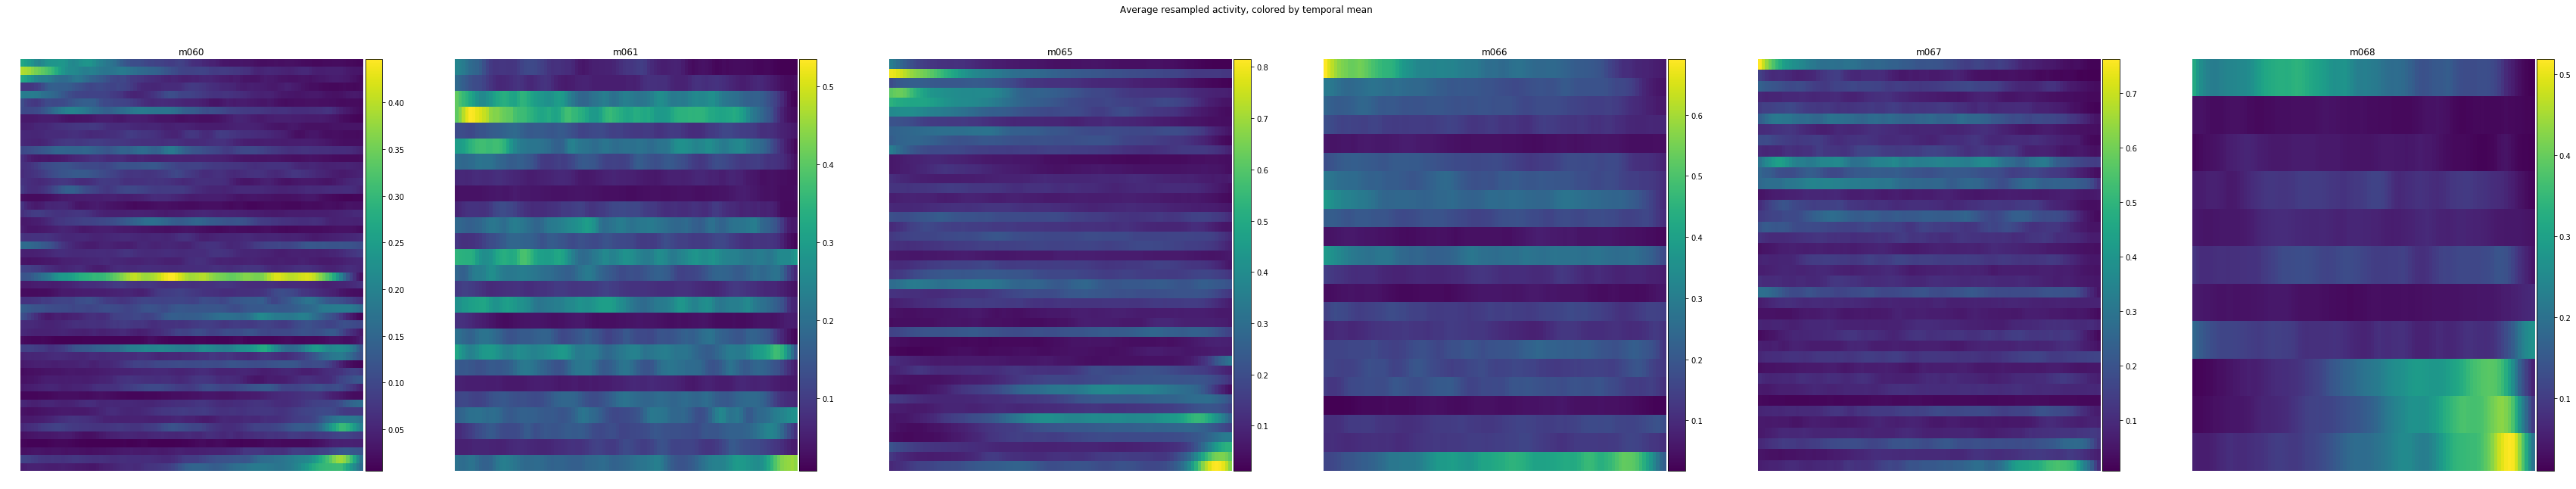

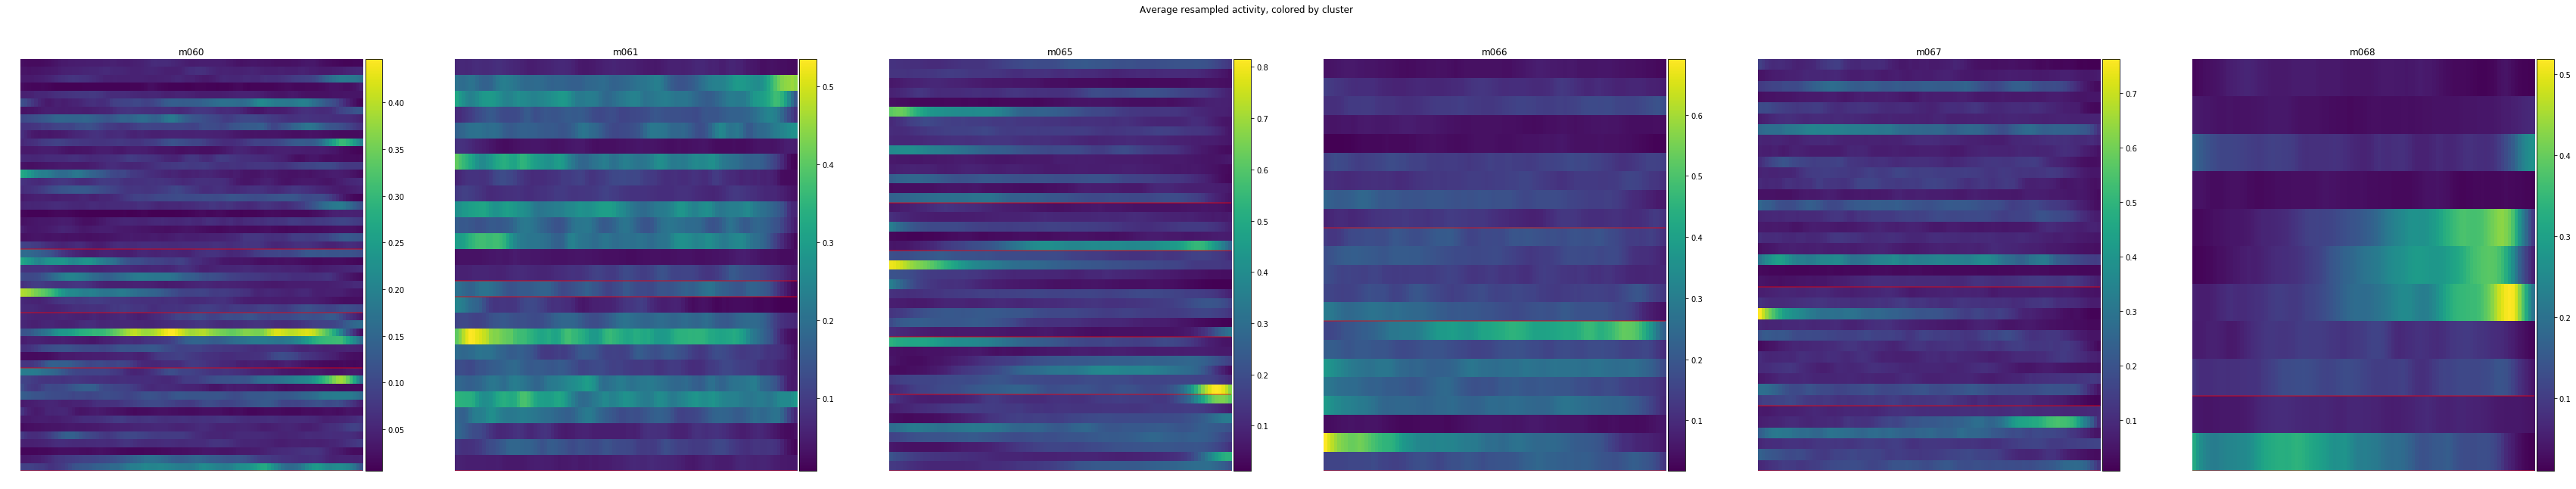

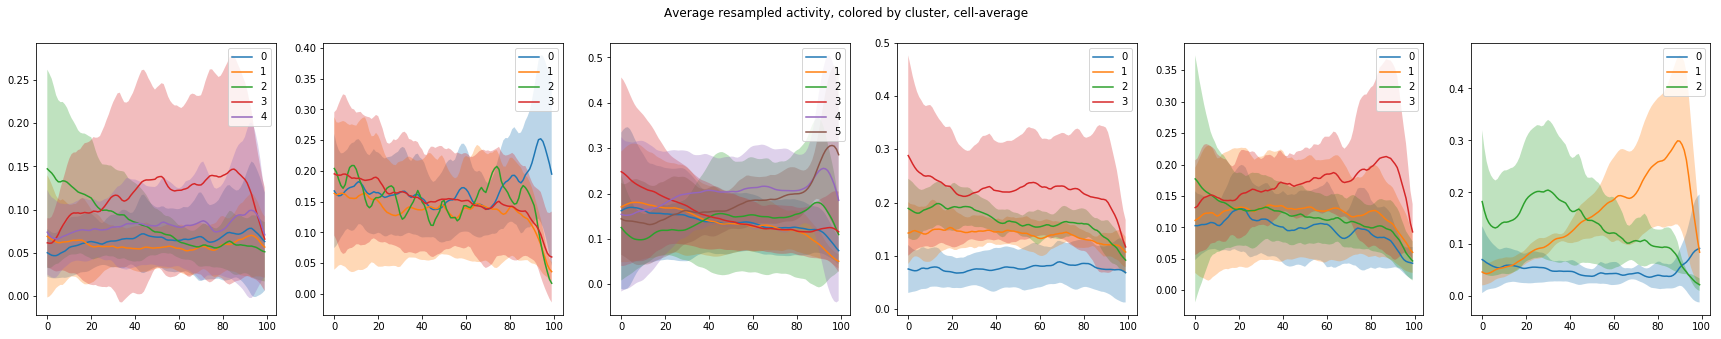

In [18]:
%%time
queryDict = {'datatype' : 'deconv'}
# plots_orderability(dataDB, queryDict, {"phase" : "Maintenance"}, nResample=200)
plots_orderability(dataDB, queryDict, {"interval" : 8}, nResample=100, signCellsMouseDict=signCellsMaintenance)

In [26]:
def plots_directed_orderability(dataDB, datatype, selector, signCellsSelector=None):    
    # Determine cell filtering
    if signCellsSelector == None:
        signCellsSelector = {'None' : None}
        
    signCellsName, signCellsMouseDict = list(signCellsSelector.items())[0]
    selectorName, selectorVal = list(selector.items())[0]
    
    
    nMice = len(dataDB.mice)
    figureProp = {
        "ord"            : (4, 4, "Directed Orderability matrices"),
        "ordSort"        : (4, 4, "Directed Orderability matrices, sorted by max directed orderability"),
        "ordSortShuffle" : (4, 4, "Directed Orderability matrices, sorted by max directed orderability, shuffled"),
        "ordMuScatter"   : (4, 4, "Relationship of average temporal mean and average directed orderability"),
        "ordShiftInv"    : (4, 4, "Relationship of difference of temporal means and directed orderability"),
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {'datatype' : datatype, 'mousename' : mousename}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        settings = {"metricSettings" : {"directed" : True}, "dropShortTrialsTHR" : 4}
        dataBinOrd = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_binary",
                                        "",
                                        selector,
                                        settings,
                                        channelFilter=signCellsMouseDict)
        
        dataTempMu = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_mean",
                                        "rp",
                                        selector,
                                        settings,
                                        channelFilter=signCellsMouseDict)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Calculate permuted orderability
        dataTempMuShuffle = sample(dataTempMu, 'permutation', permAxis=1, iterAxis=0)
        dataBinOrdShuffle = bivariate_orderability_from_temporal_mean(dataTempMuShuffle, {"directed" : True})
        meanBinOrd1DShuffle = np.nanmean(dataBinOrdShuffle, axis=0)
        idxSortBinOrdShuffle = np.argsort(meanBinOrd1DShuffle)[::-1]
        dataBinOrdSortedShuffle = mat_order_by_idx(dataBinOrdShuffle, idxSortBinOrdShuffle)
        
        # Calculate difference matrix of temporal means
        dataTempMuAvg = np.mean(dataTempMu, axis=0)
        diffTempMu = pairwise_subtract(dataTempMuAvg)
        diffTempMu1D = get_mat_triu_elems(diffTempMu)
        dataBinOrd1D = get_mat_triu_elems(dataBinOrd)
                
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        imshow(*getfigs("ordSortShuffle"), dataBinOrdSortedShuffle, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        getfigs("ordMuScatter")[1].plot(dataTempMuAvg, meanBinOrd1D, '.')
        
        getfigs("ordShiftInv")[1].plot(diffTempMu1D, dataBinOrd1D, '.')
        getfigs("ordShiftInv")[1].axhline(y=0, linestyle='--', color='r')
        getfigs("ordShiftInv")[1].axvline(x=0, linestyle='--', color='r')
        
        
    suffix = '_'.join([datatype, selectorName, signCellsName])
        
    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig("directed_"+ key + '_' + suffix + '.pdf')

('raw', 'M1', 'None')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('raw', 'M1', 'Maintenance')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('raw', 'M1', 'Reward')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('raw', 'M2', 'None')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('raw', 'M2', 'Maintenance')
Doing mouse m060


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('raw', 'M2', 'Reward')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M1', 'None')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M1', 'Maintenance')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M1', 'Reward')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M2', 'None')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M2', 'Maintenance')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
('deconv', 'M2', 'Reward')
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


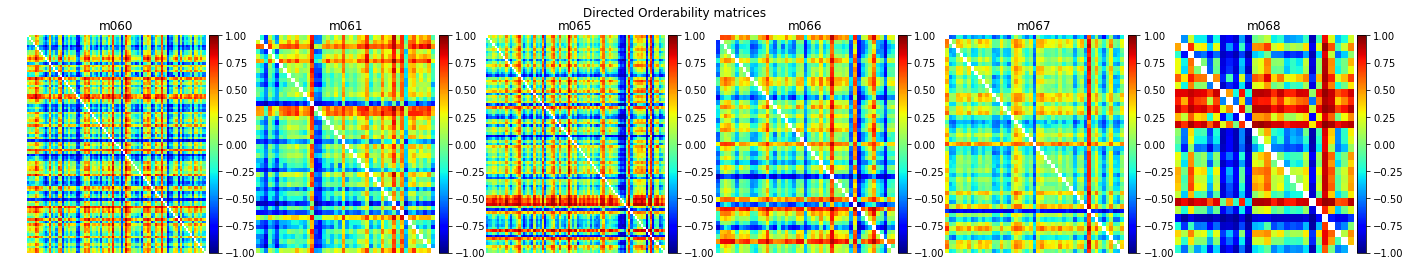

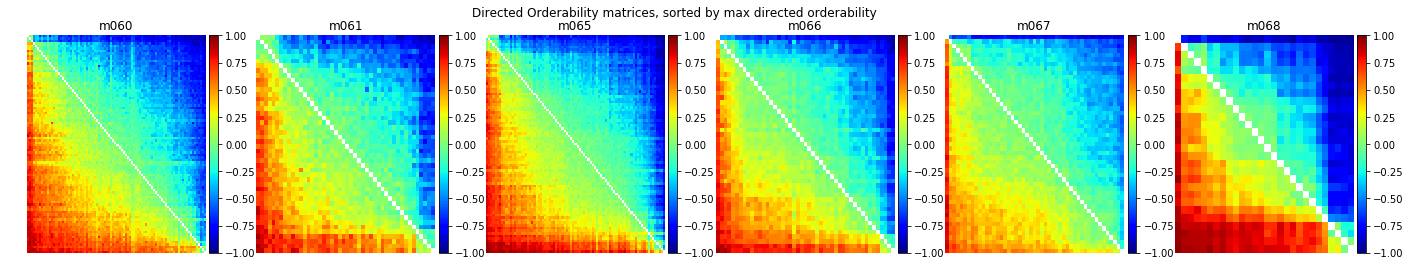

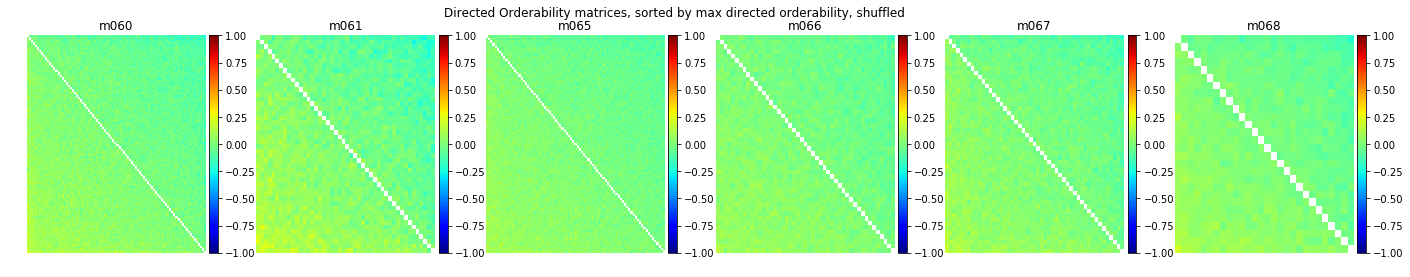

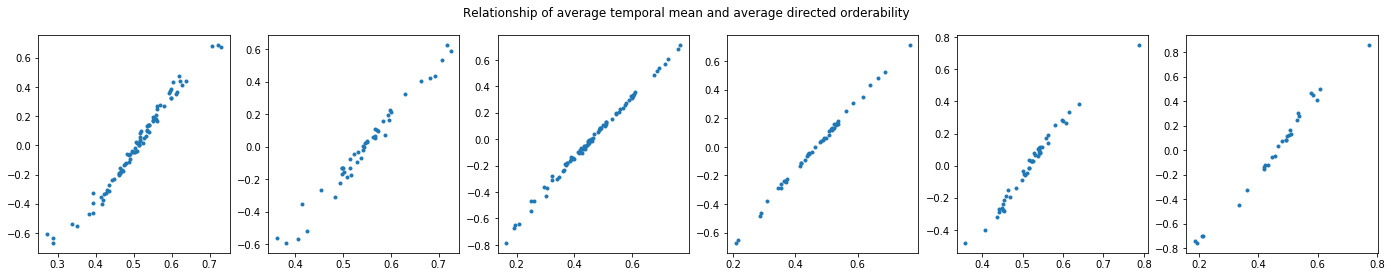

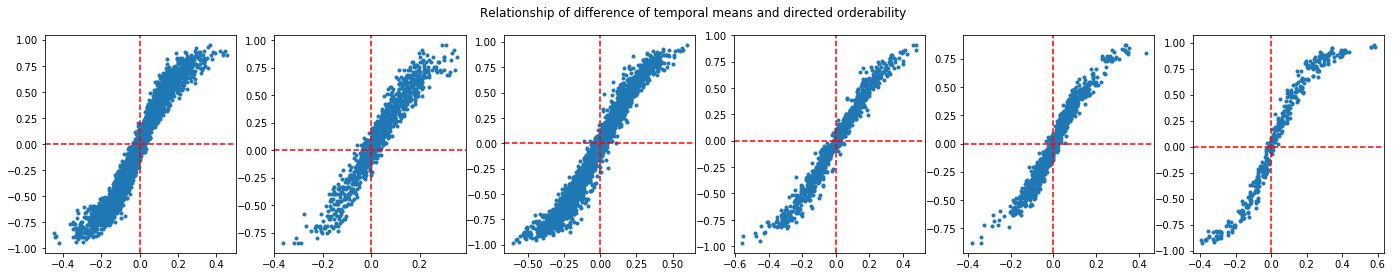

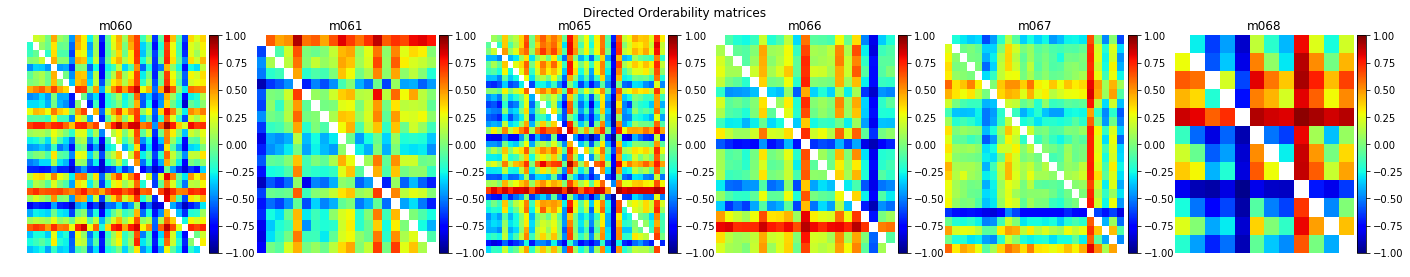

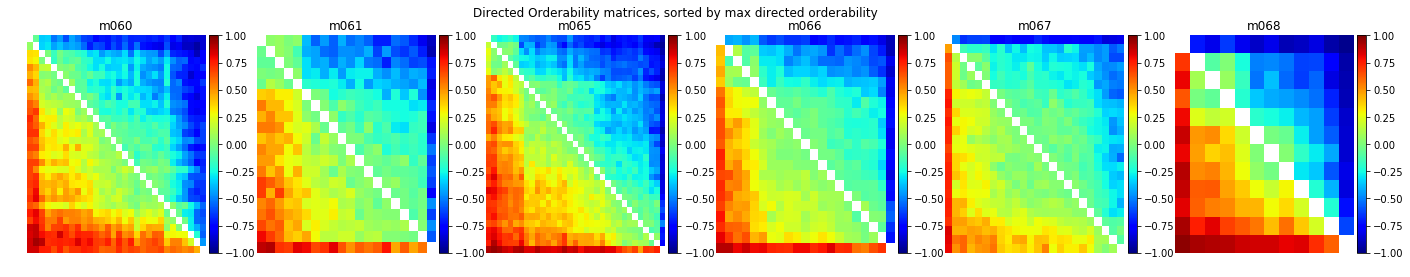

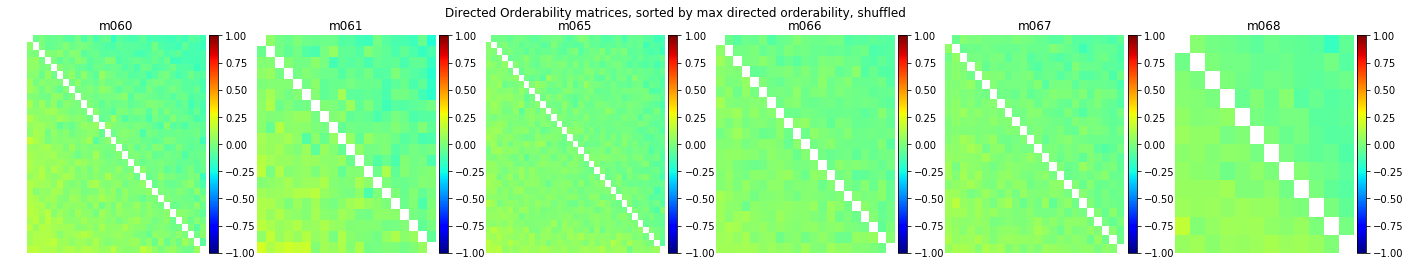

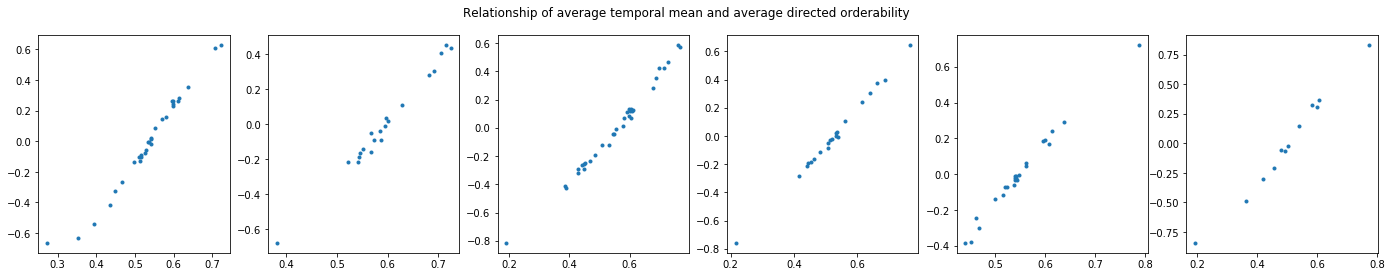

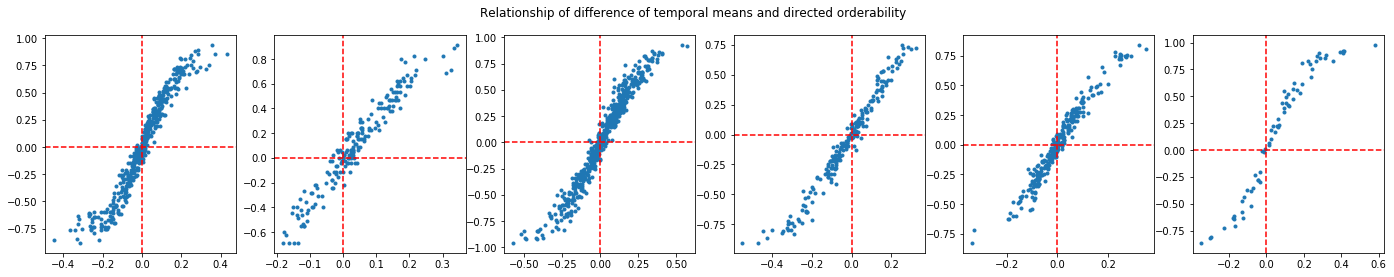

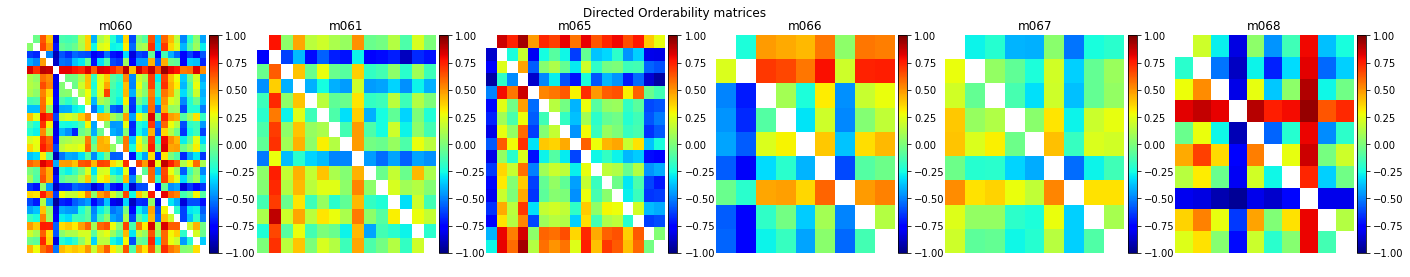

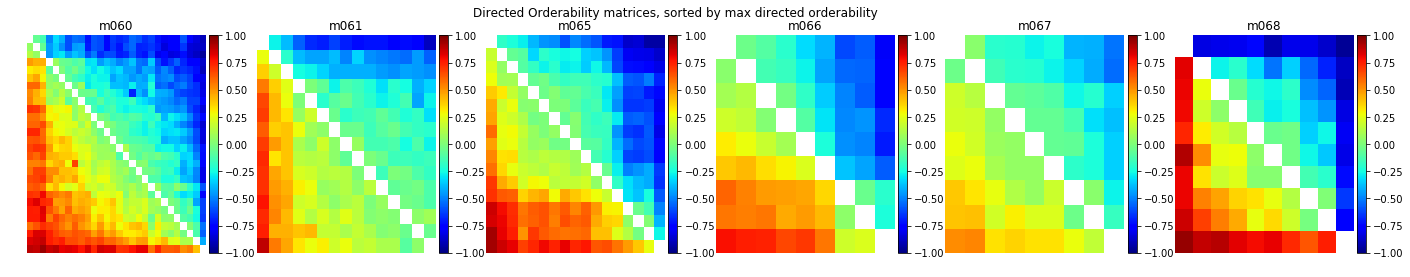

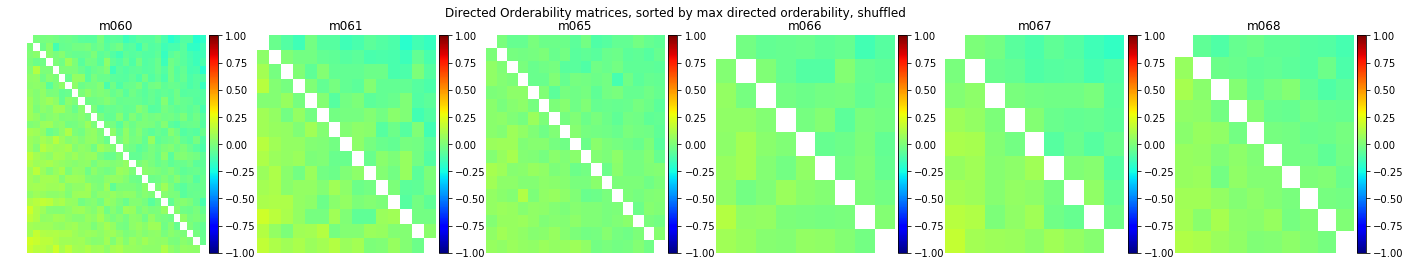

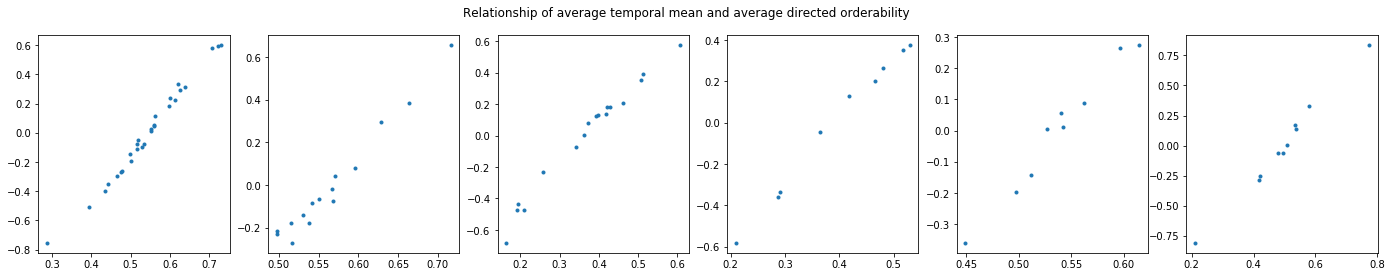

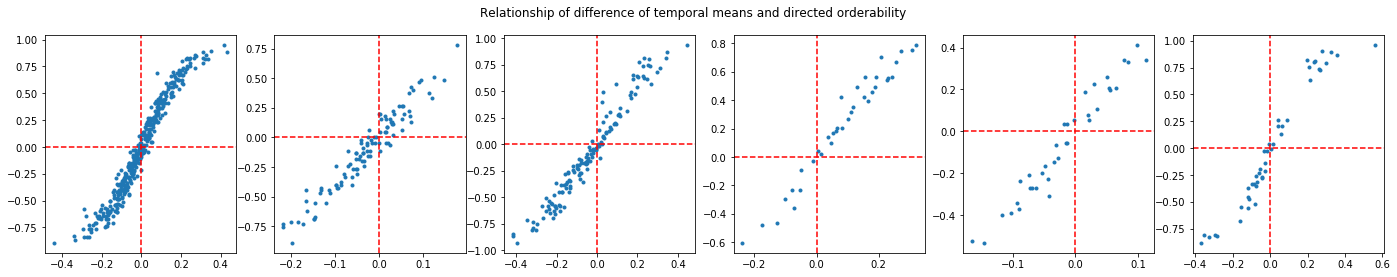

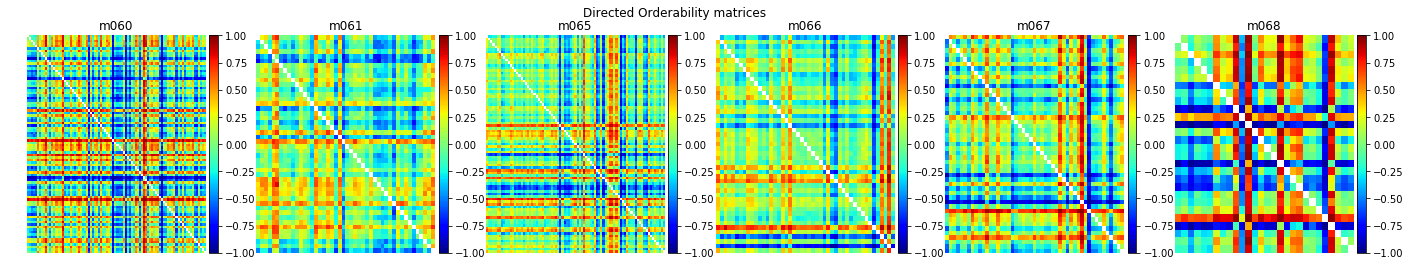

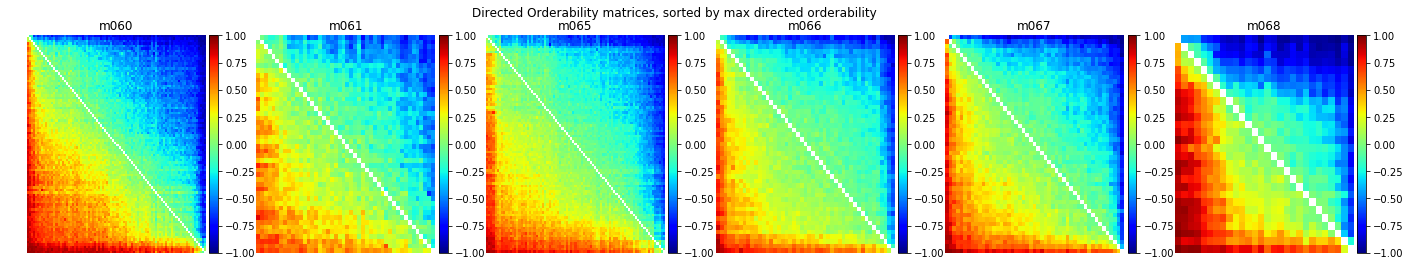

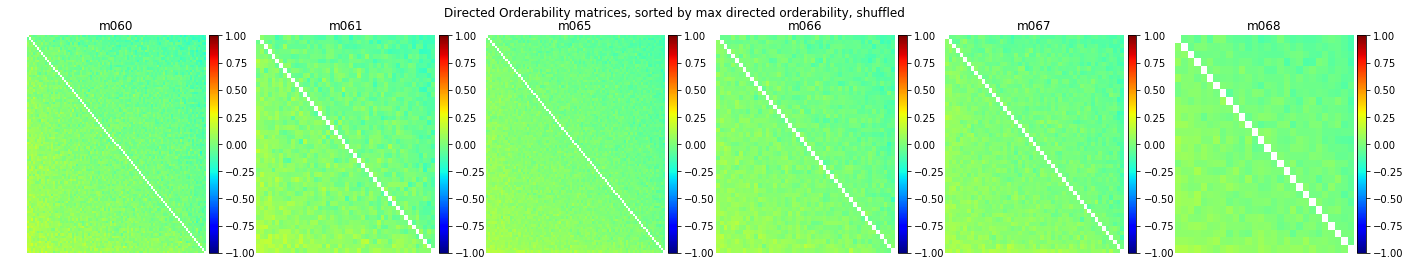

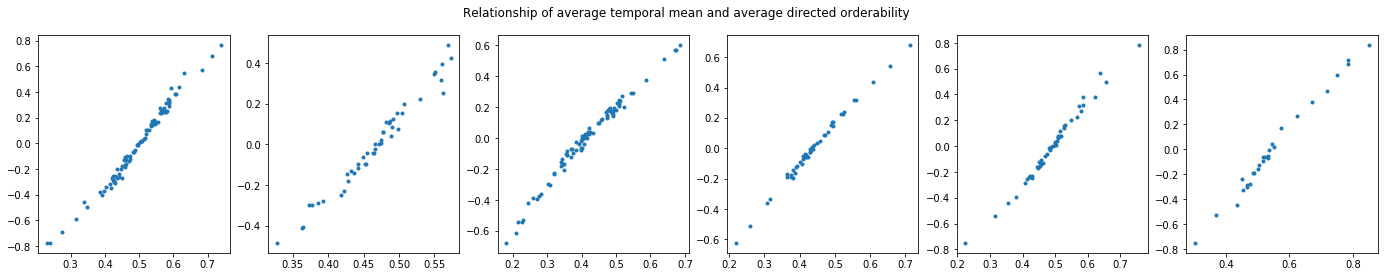

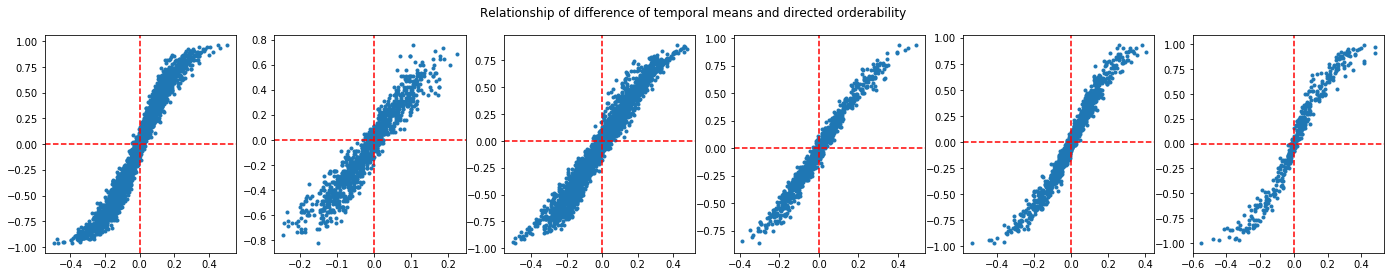

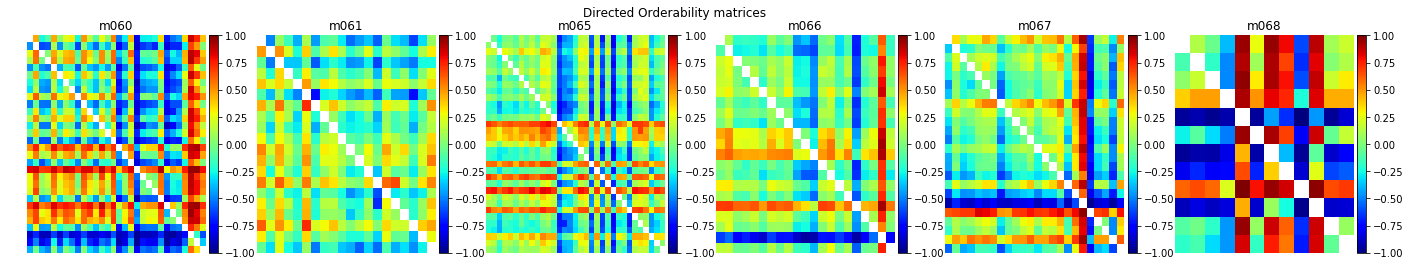

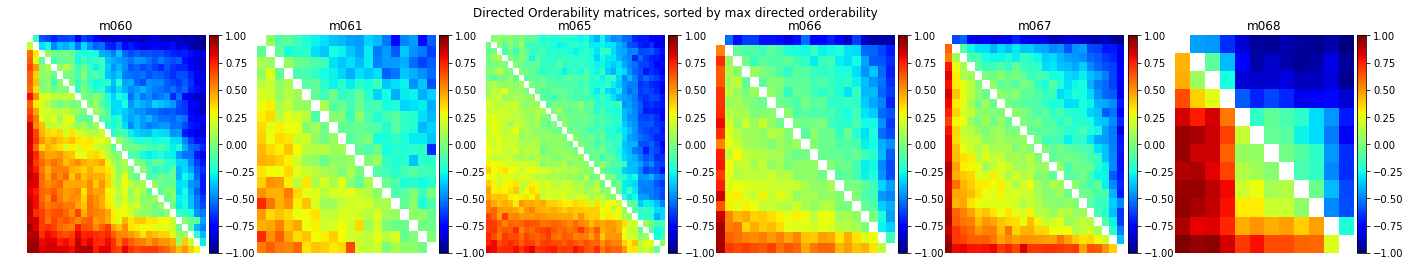

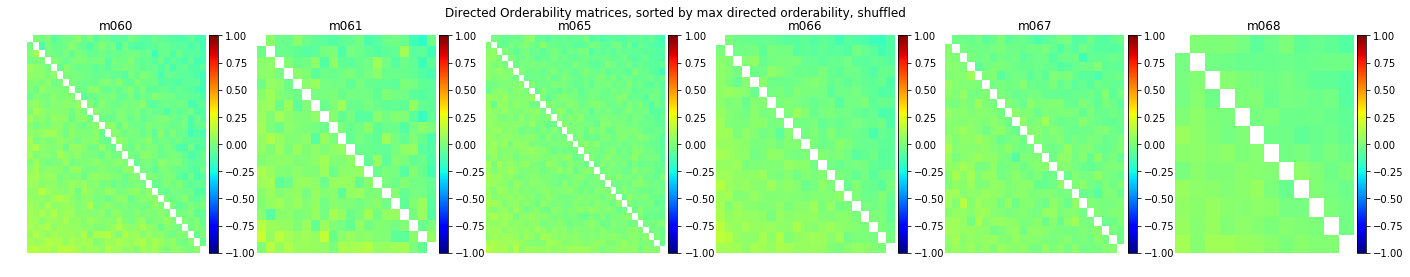

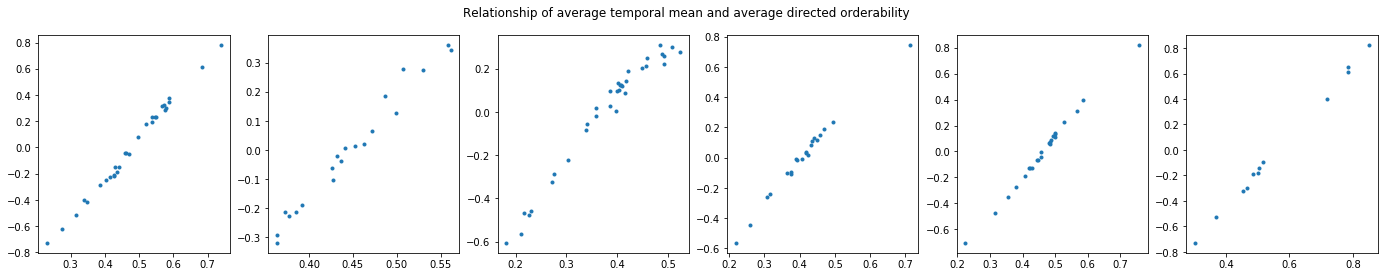

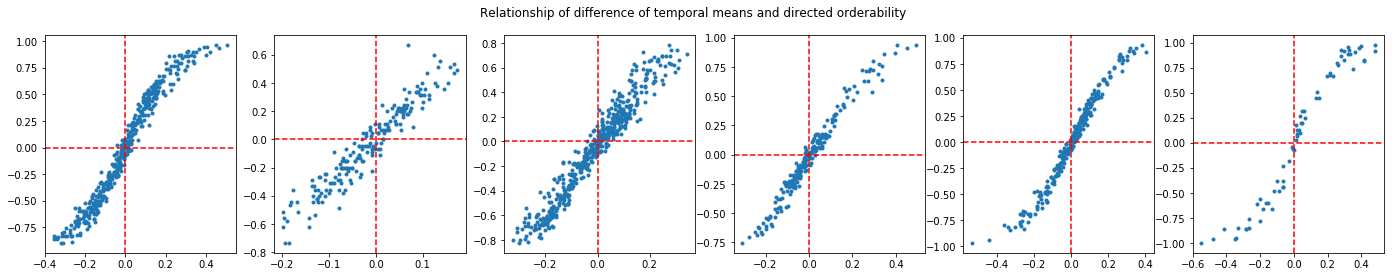

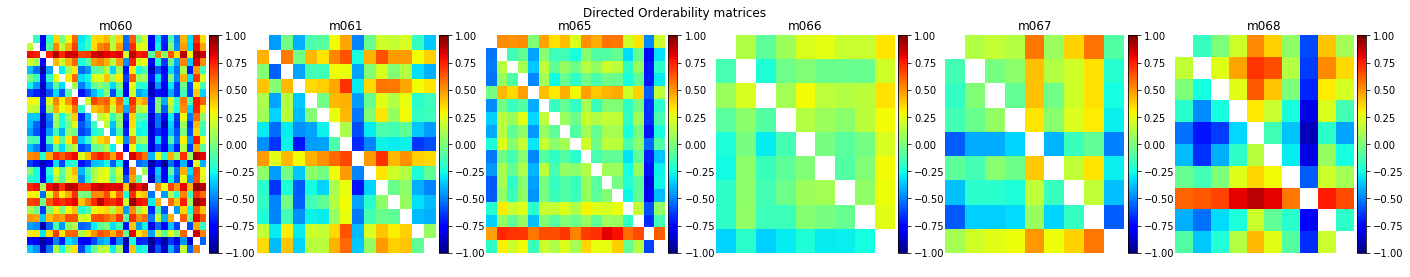

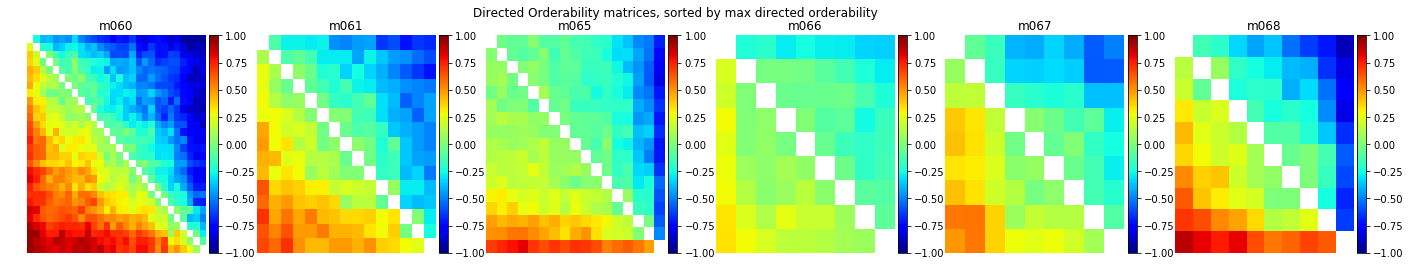

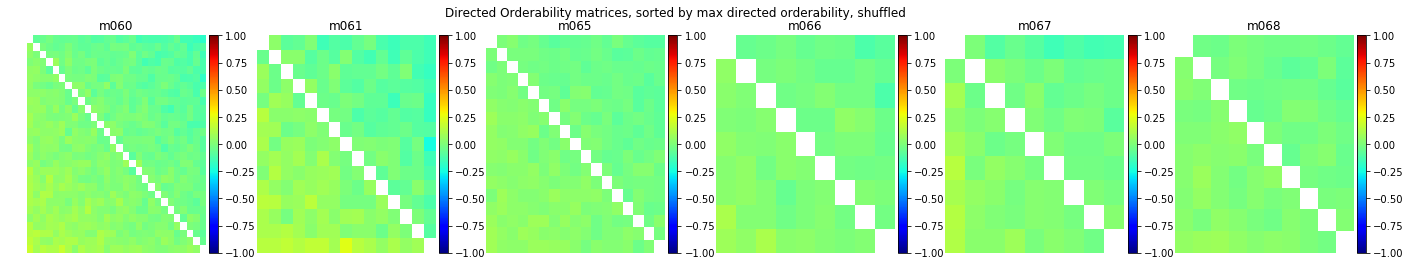

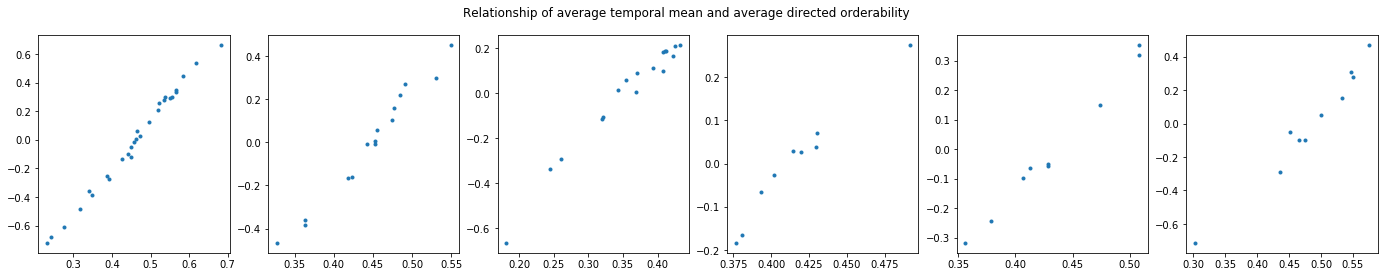

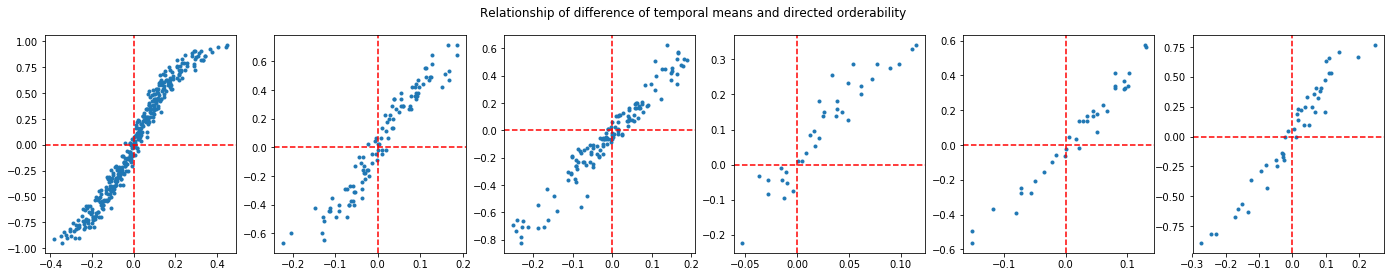

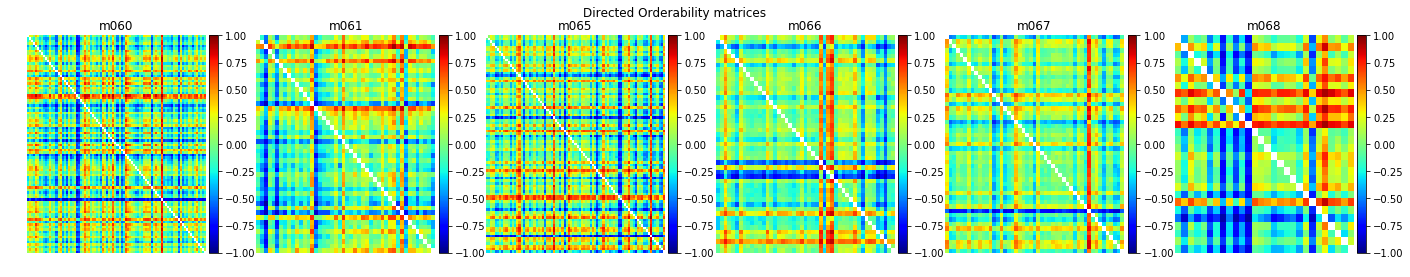

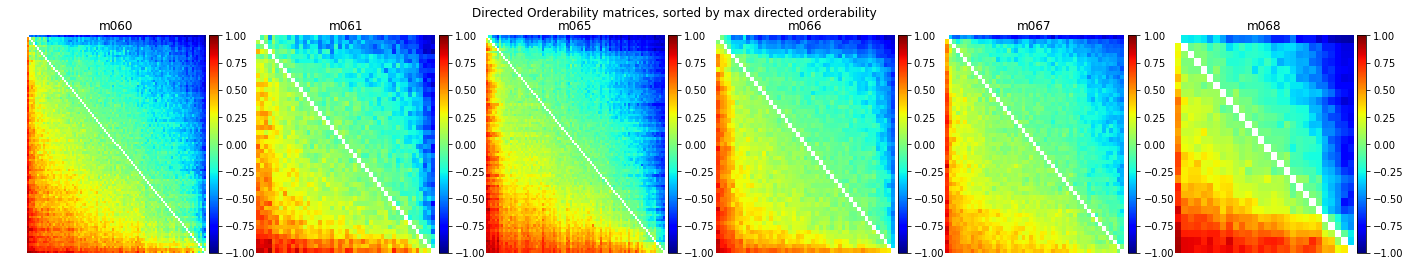

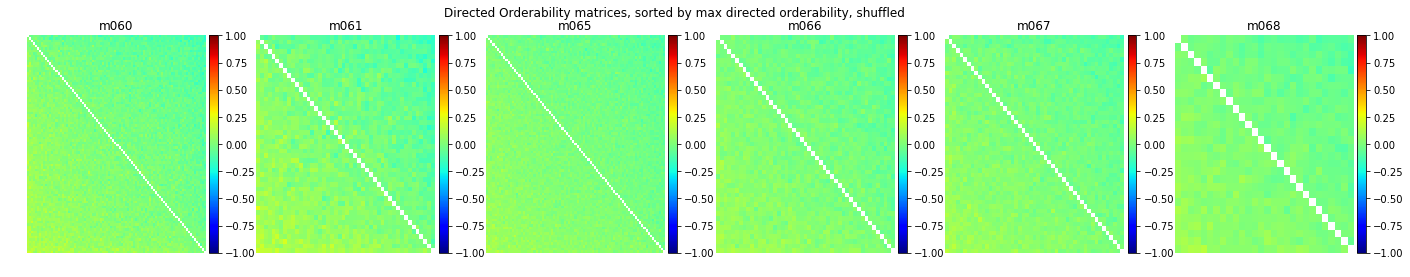

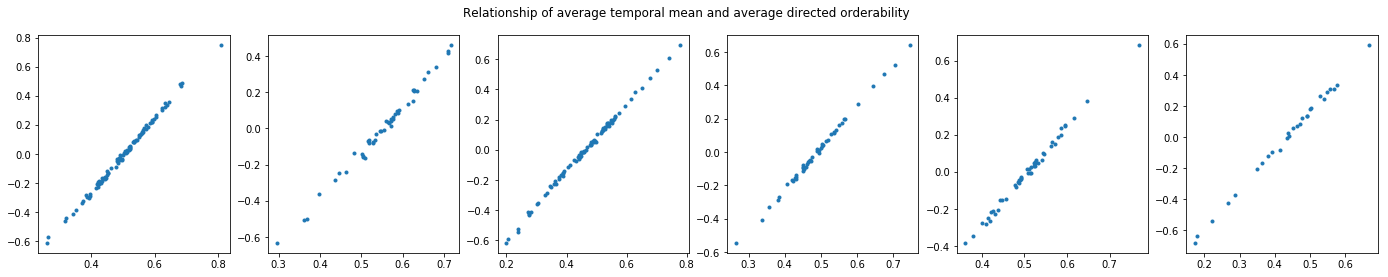

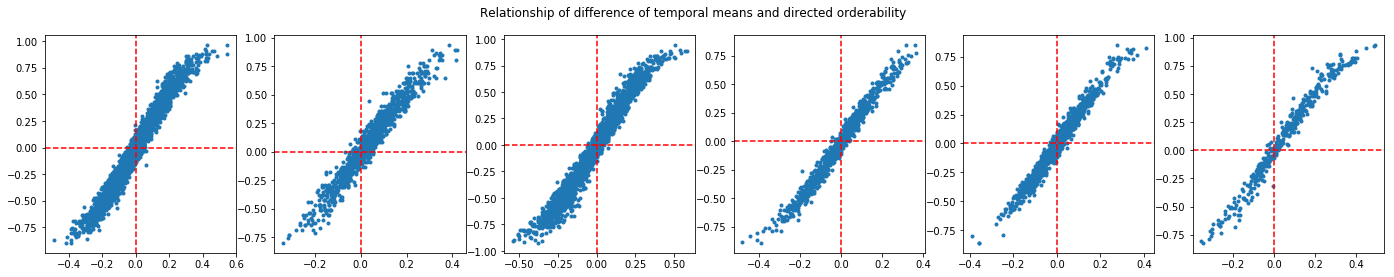

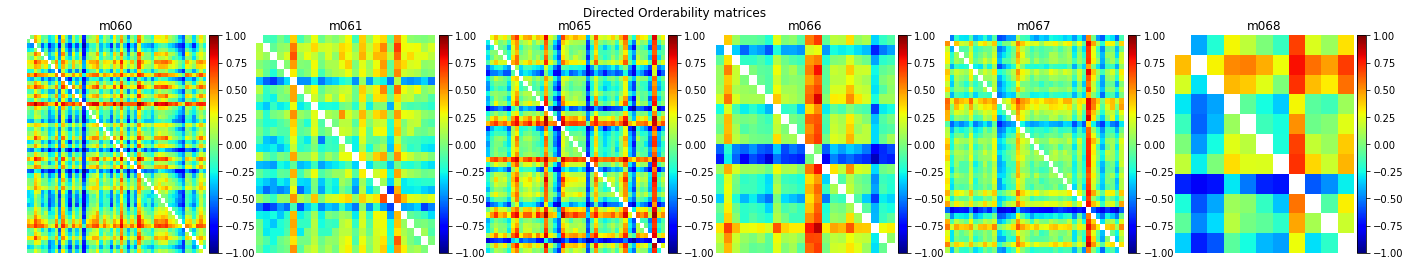

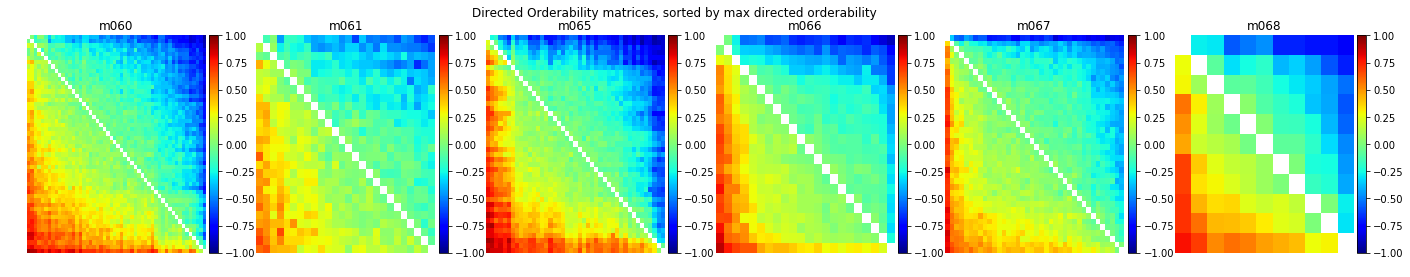

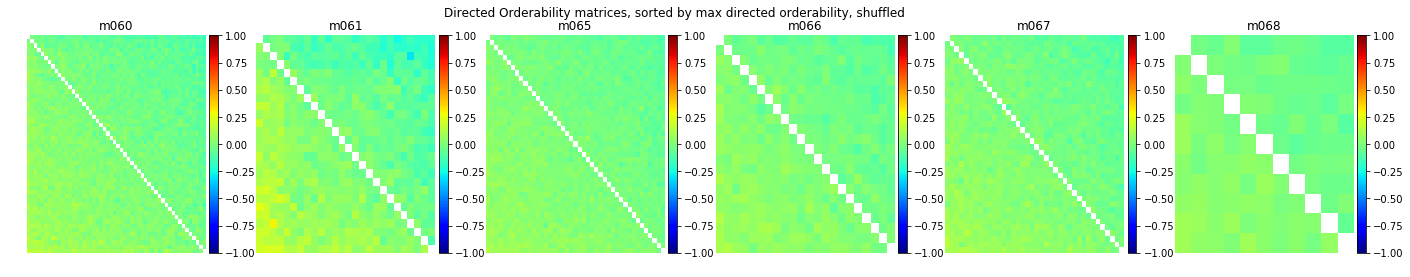

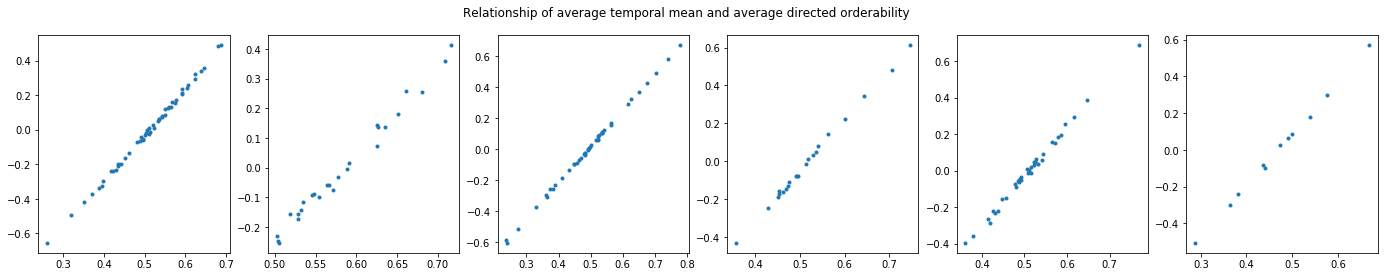

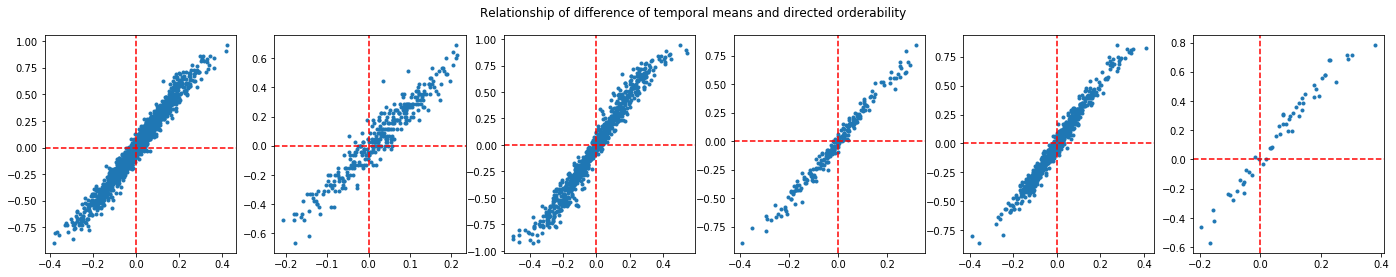

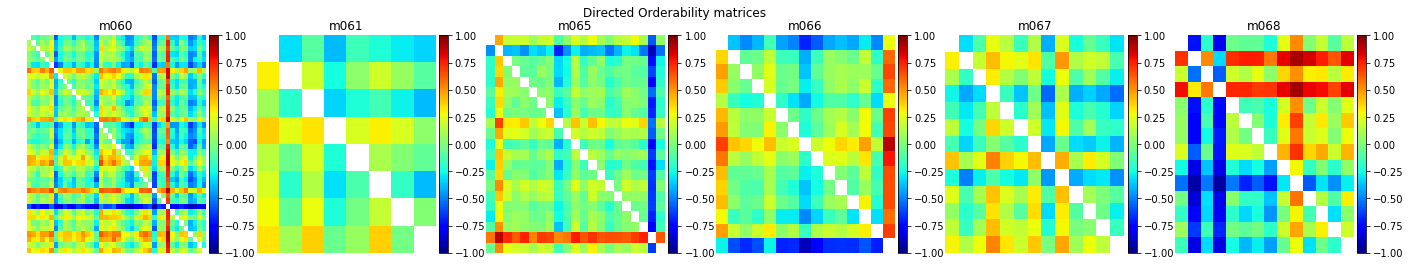

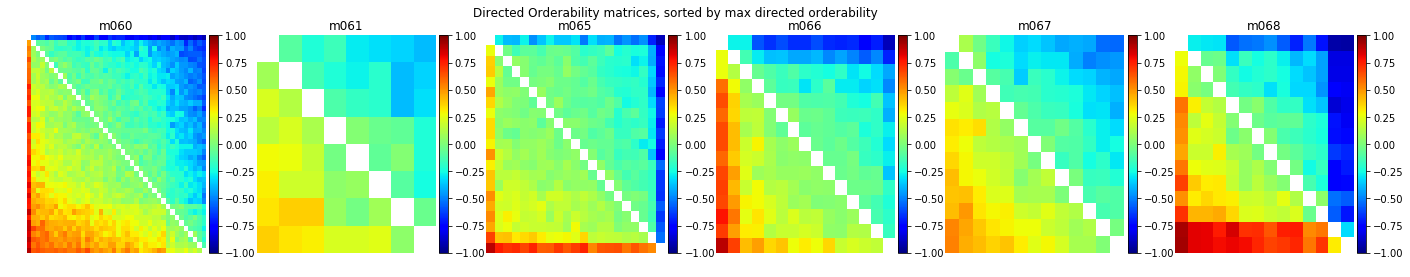

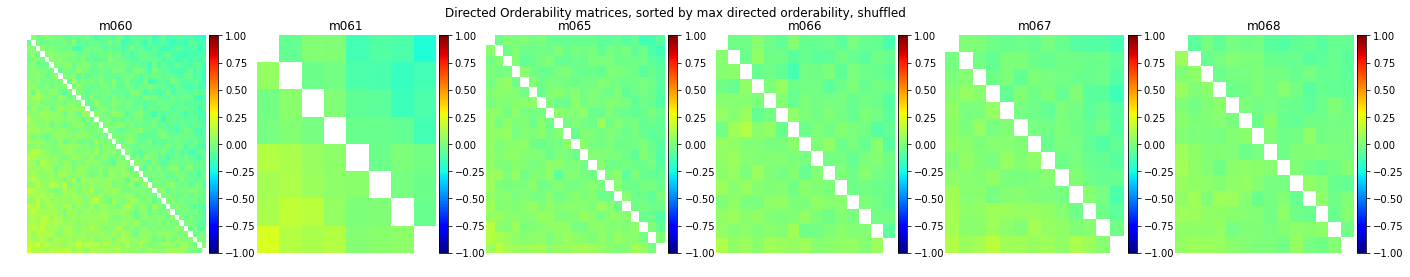

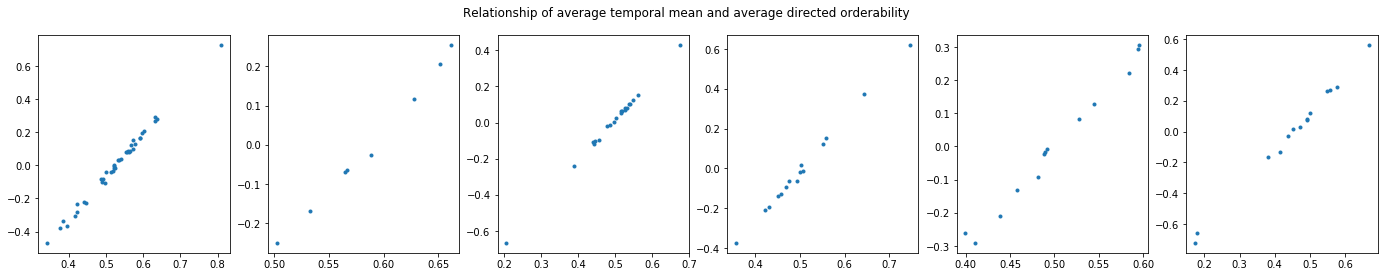

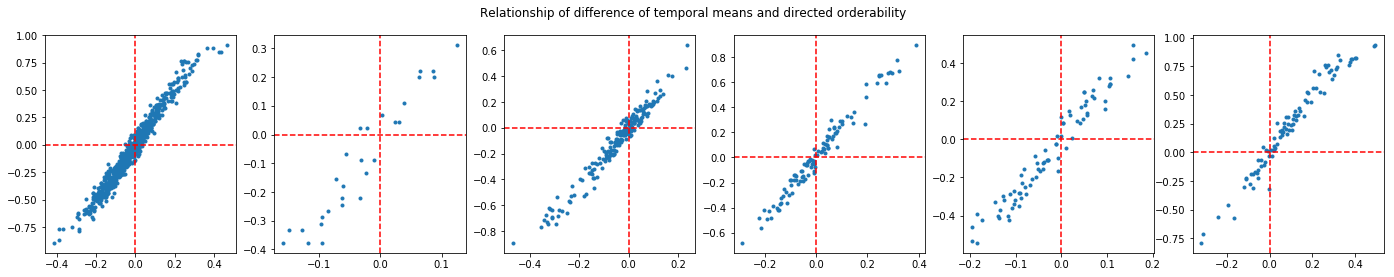

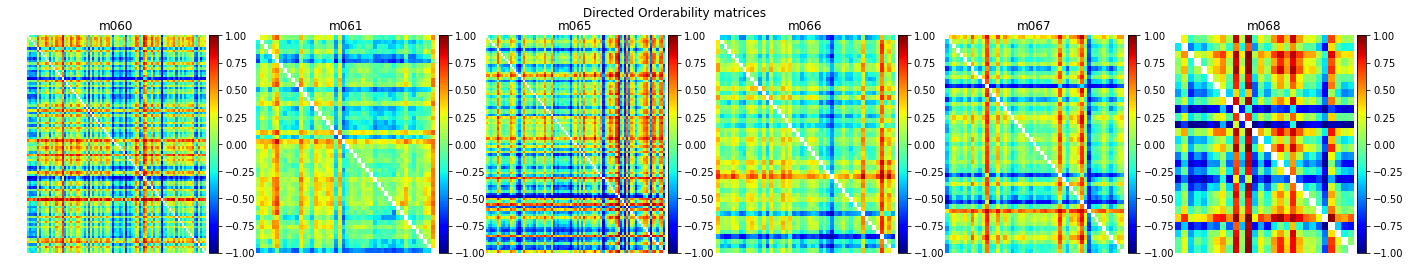

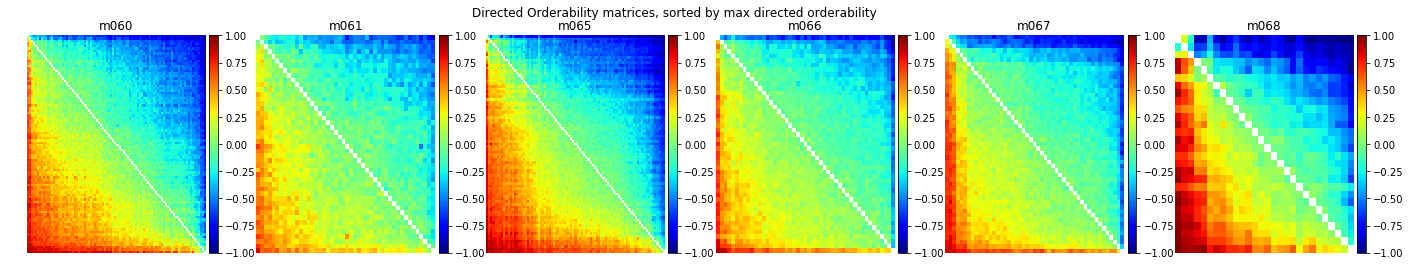

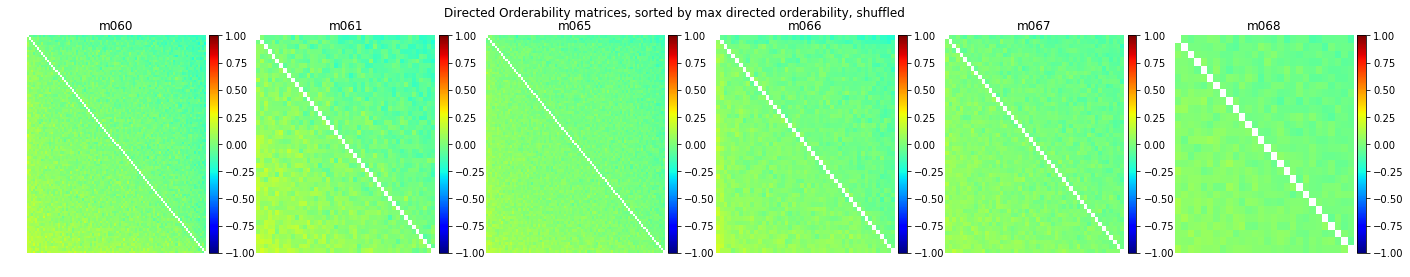

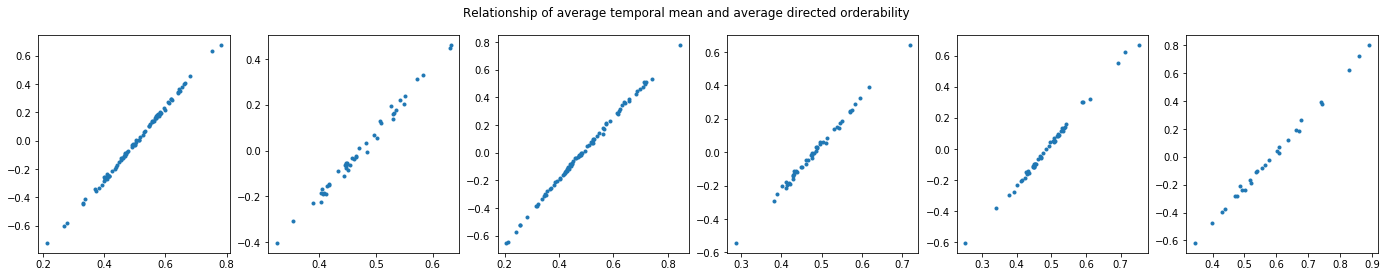

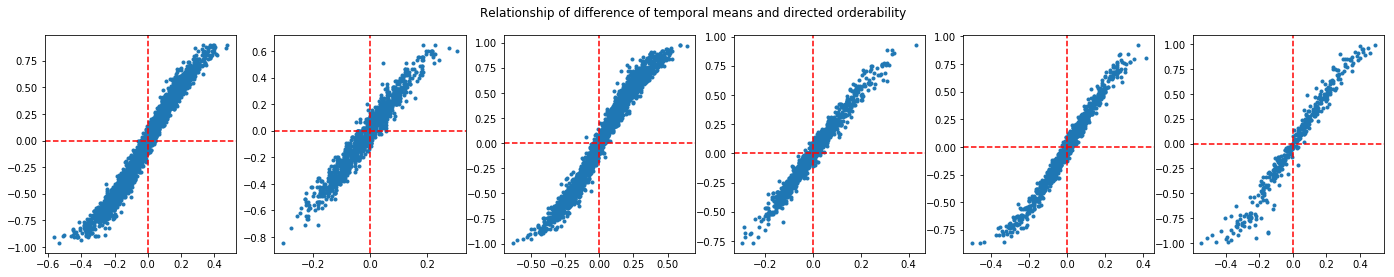

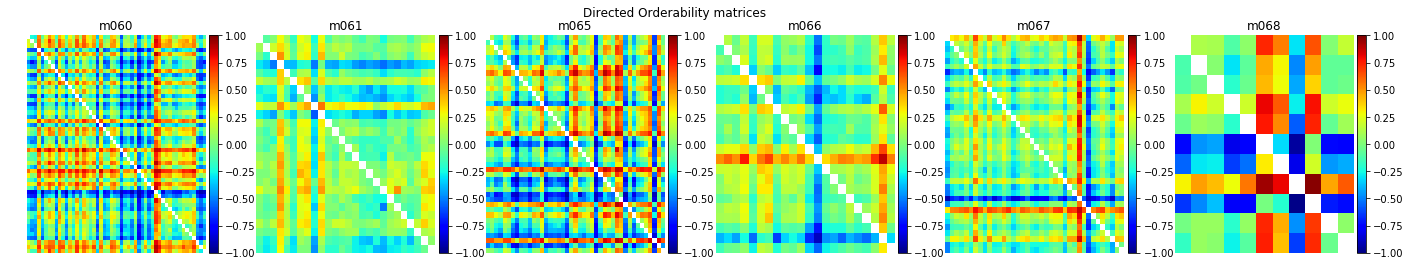

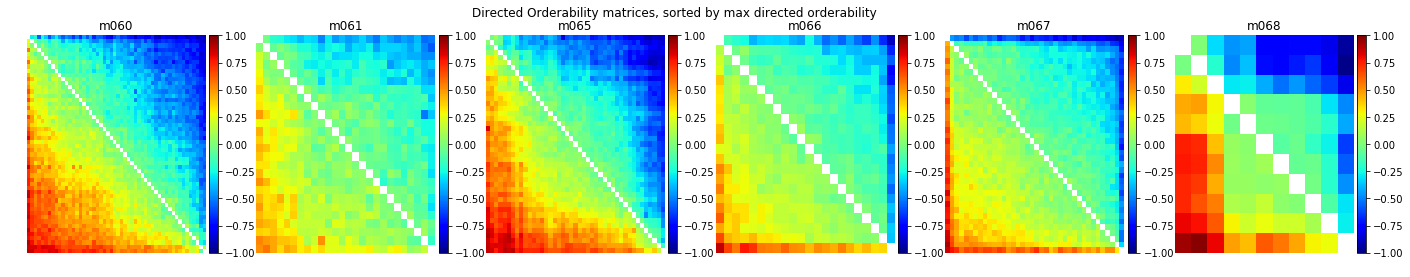

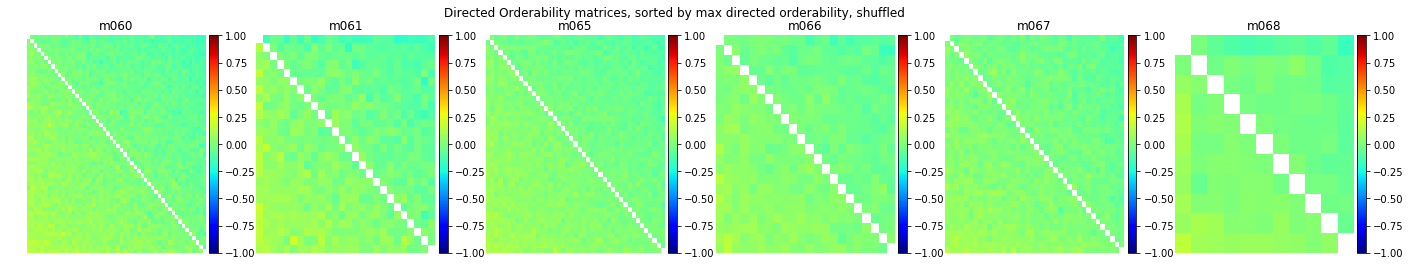

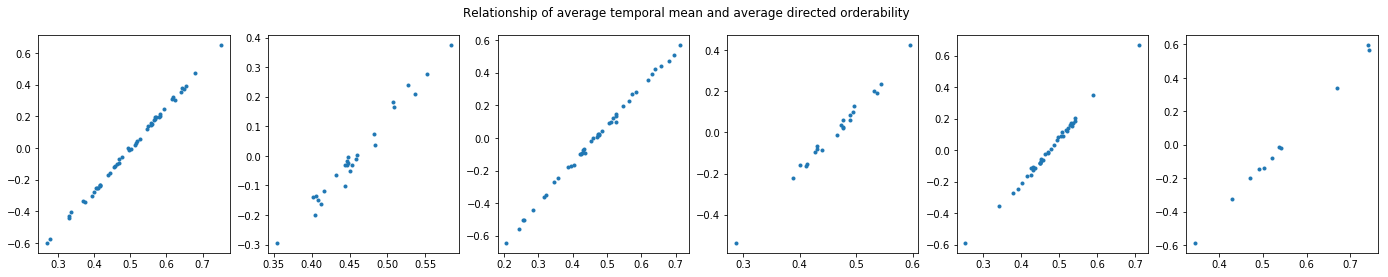

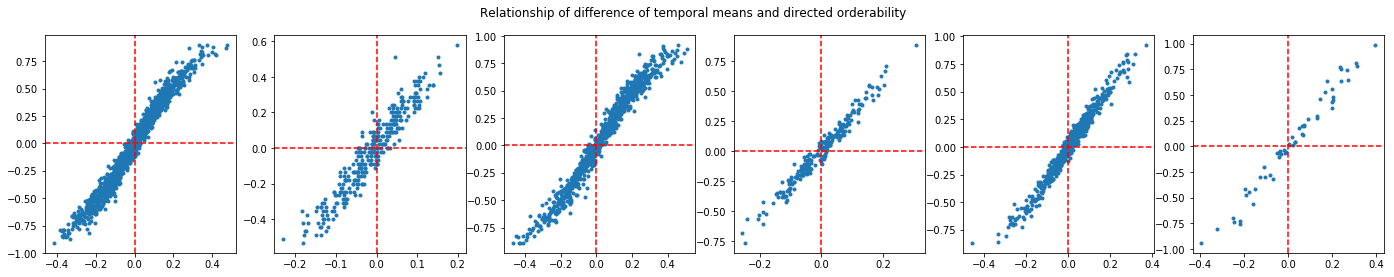

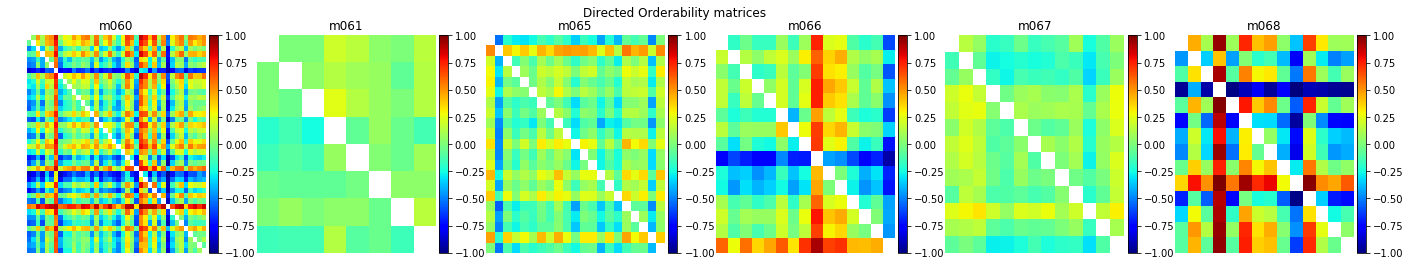

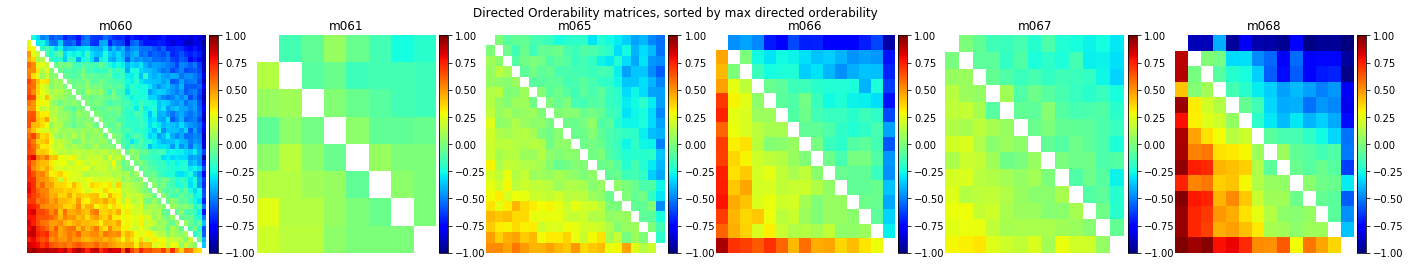

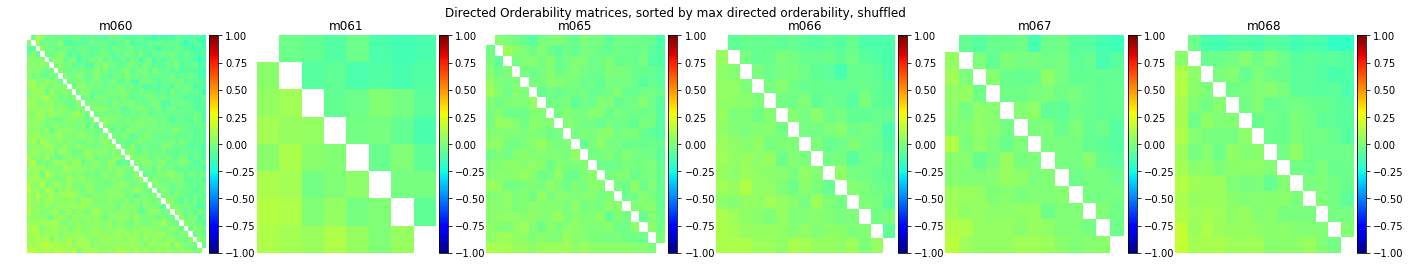

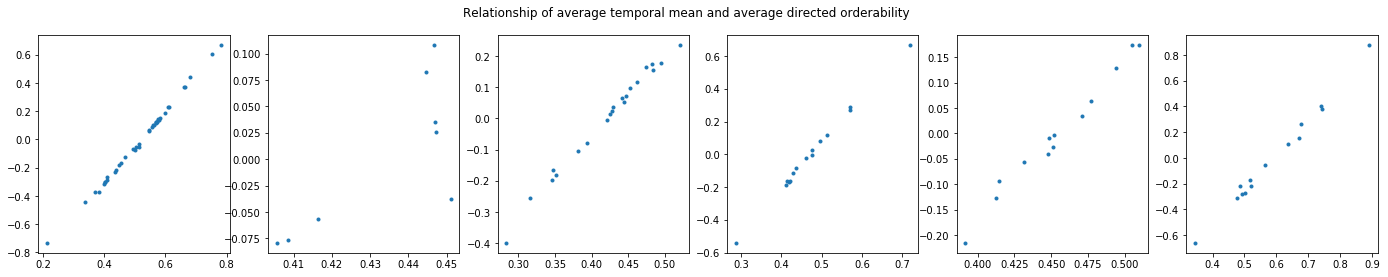

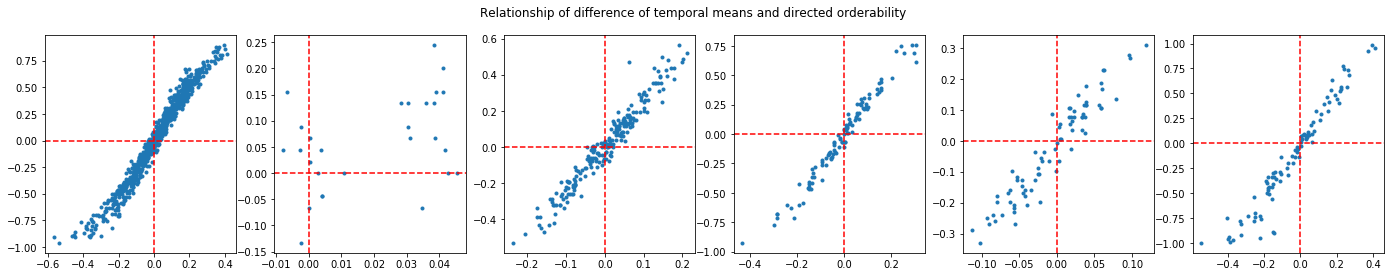

In [35]:
for datatype in ['raw', 'deconv']:
#     for interval in range(6, 9):
    for semiphase in ['M1', 'M2']:
        for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
            key = (datatype, semiphase, signCellsName)
            print(key)

#             selector = {"interval" : interval}
            selector = {"semiphase" : semiphase}
#             selector = {"phase" : "Maintenance"}
            plots_directed_orderability(dataDB, datatype, selector, signCellsSelector={signCellsName : signCells})

In [51]:
def test_average_orderability(dataDB, datatype, phasetype, performance, signCellsSelector=None, haveWaiting=False):    
    # Determine cell filtering
    if signCellsSelector == None:
        signCellsSelector = {'None' : None}
        
    signCellsName, signCellsMouseDict = list(signCellsSelector.items())[0]
    
    
    nMice = len(dataDB.mice)
    
    figTot, axTot = plt.subplots(figsize=(4,4))
    axTot.set_ylabel("AvgBinOrd")
    
    fig, ax = plt.subplots(nrows=2, ncols=nMice, figsize=(nMice*4, 2*4))
    ax[0, 0].set_ylabel("AvgBinOrd")
    ax[1, 0].set_ylabel("Effect tize")
    
    phaseKeys = dataDB.get_phasetype_keys(phasetype, performance, haveWaiting=haveWaiting)
    
    print(phaseKeys)
    
    xDummy = np.arange(1, len(phaseKeys)+1)
    
    fTrueAllLst = []
    fRandAllLst = []
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {'datatype' : datatype, 'mousename' : mousename, 'performance' : performance}
        
        fTrueLst = []
        fRandLst = []
        effSizeLst = []
        
        for phaseKey in phaseKeys:
        
            # Calculate orderability and temporal means
            settings = {"dropShortTrialsTHR" : 4}
            dataTempMu = metric_by_selector(
                dataDB,
                queryDictThis,
                "ord_mean",
                "rp",
                {phasetype : phaseKey},
                settings,
                channelFilter=signCellsMouseDict)

            func_ABO = avg_bivariate_binary_orderability_from_temporal_mean

            permSettings = {"haveEffectSize":True, "haveMeans":True}
            pValL, pValR, effSize, fTrue, fRand = perm_test(
                func_ABO, dataTempMu, permAxis=1, iterAxis=0, nSample=200, settings=permSettings)
            
            fTrueLst += [fTrue]
            fRandLst += [fRand]
            effSizeLst += [effSize]
            
        fTrueAllLst += [fTrueLst]
        fRandAllLst += [fRandLst]
            
        ax[0, iMouse].set_title(mousename)
        ax[0, iMouse].plot(xDummy, fTrueLst)
        ax[0, iMouse].plot(xDummy, fRandLst, '--r')
        ax[1, iMouse].plot(xDummy, effSizeLst)
        
#         ax[0, iMouse].axvline(x=5.5, linestyle='--', color='y')
#         ax[0, iMouse].axvline(x=8.5, linestyle='--', color='y')
#         ax[1, iMouse].axvline(x=5.5, linestyle='--', color='y')
#         ax[1, iMouse].axvline(x=8.5, linestyle='--', color='y')
        
        ax[0, iMouse].set_ylim([0, None])
        ax[1, iMouse].set_ylim([0, None])
        ax[0, iMouse].set_xticks(xDummy)
        ax[1, iMouse].set_xticks(xDummy)
        ax[0, iMouse].set_xticklabels(phaseKeys)
        ax[1, iMouse].set_xticklabels(phaseKeys)
    
    muTrue =  np.mean(fTrueAllLst, axis=0)
    muRand =  np.mean(fRandAllLst, axis=0)
    stdTrue =  np.std(fTrueAllLst, axis=0)
    
    axTot.set_title('Allmice')
    axTot.plot(xDummy, muTrue, color='blue')
    axTot.fill_between(xDummy, muTrue-stdTrue, muTrue+stdTrue, color='blue', alpha=0.3)
    axTot.plot(xDummy, muRand, '--r')
    
    
#     axTot.axvline(x=5.5, linestyle='--', color='y')
#     axTot.axvline(x=8.5, linestyle='--', color='y')
    axTot.set_ylim([0, None])
    axTot.set_xticks(xDummy)
    axTot.set_xticklabels(phaseKeys)
    
    plt.figure(figTot.number)
    plt.savefig(datatype + '_' + signCellsName + "_orderability_test_by_intervals_allmice.pdf")
    
    plt.figure(fig.number)
    plt.savefig(datatype + '_' + signCellsName + "_orderability_test_by_intervals.pdf")
    plt.show()

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


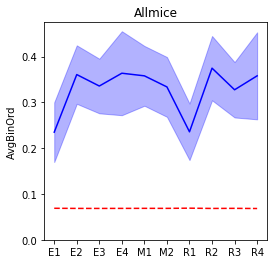

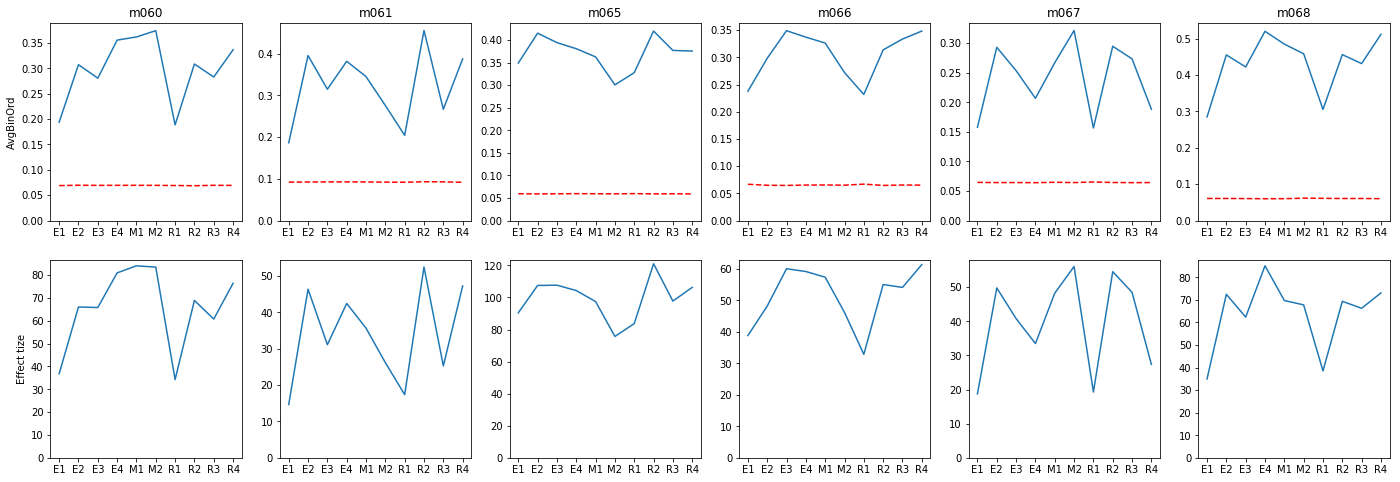

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


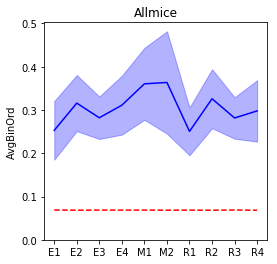

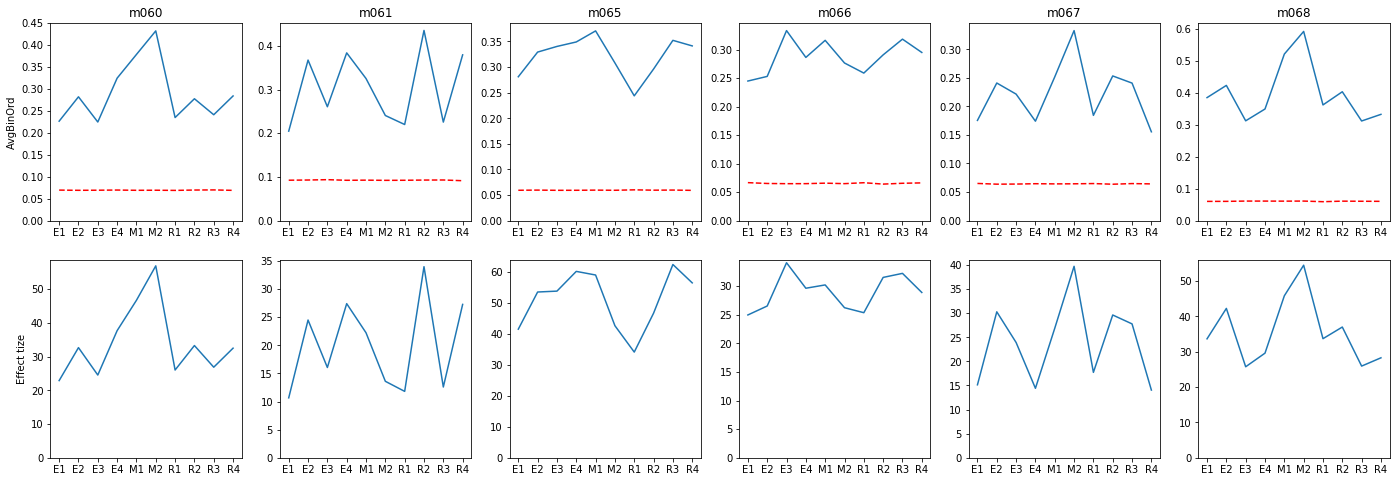

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


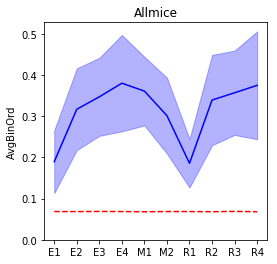

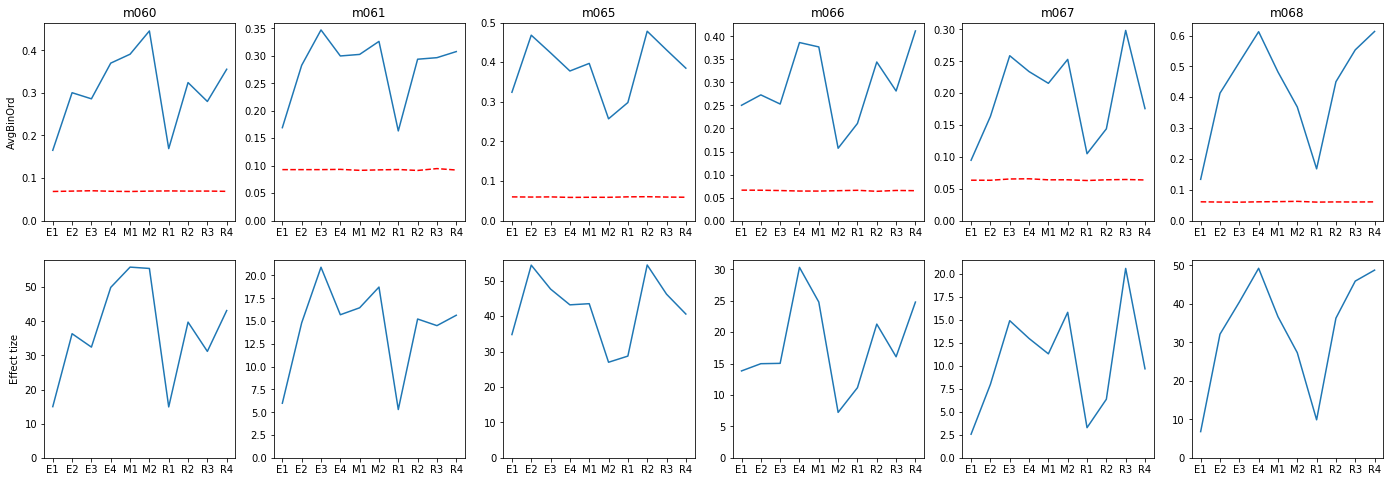

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


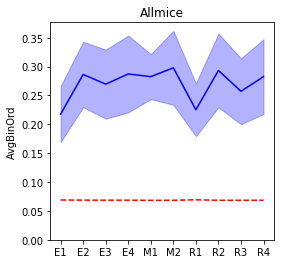

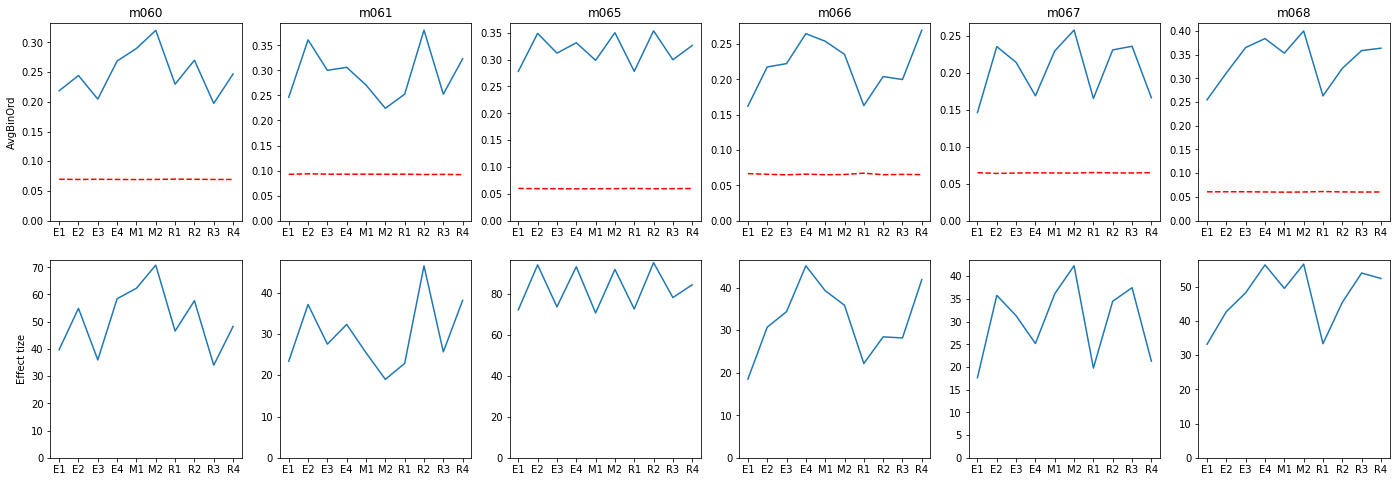

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


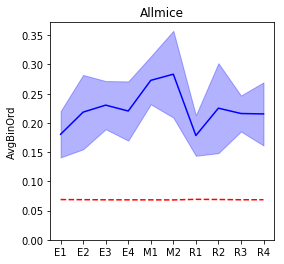

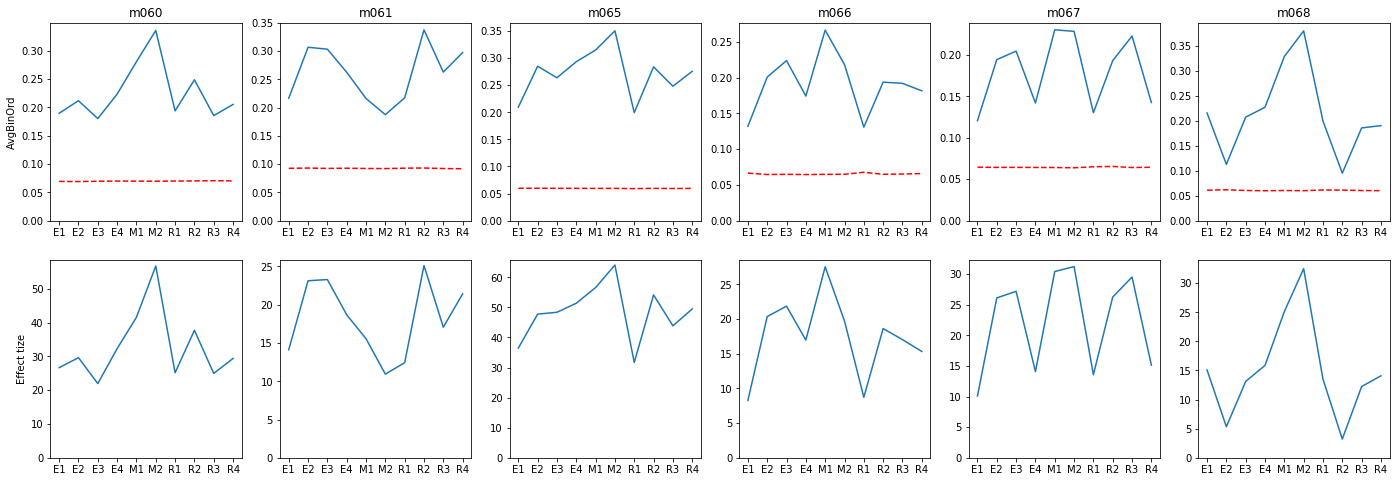

['E1', 'E2', 'E3', 'E4', 'M1', 'M2', 'R1', 'R2', 'R3', 'R4']
Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


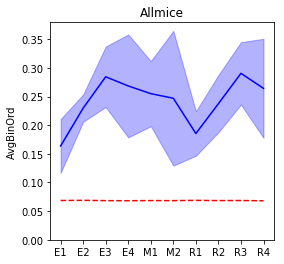

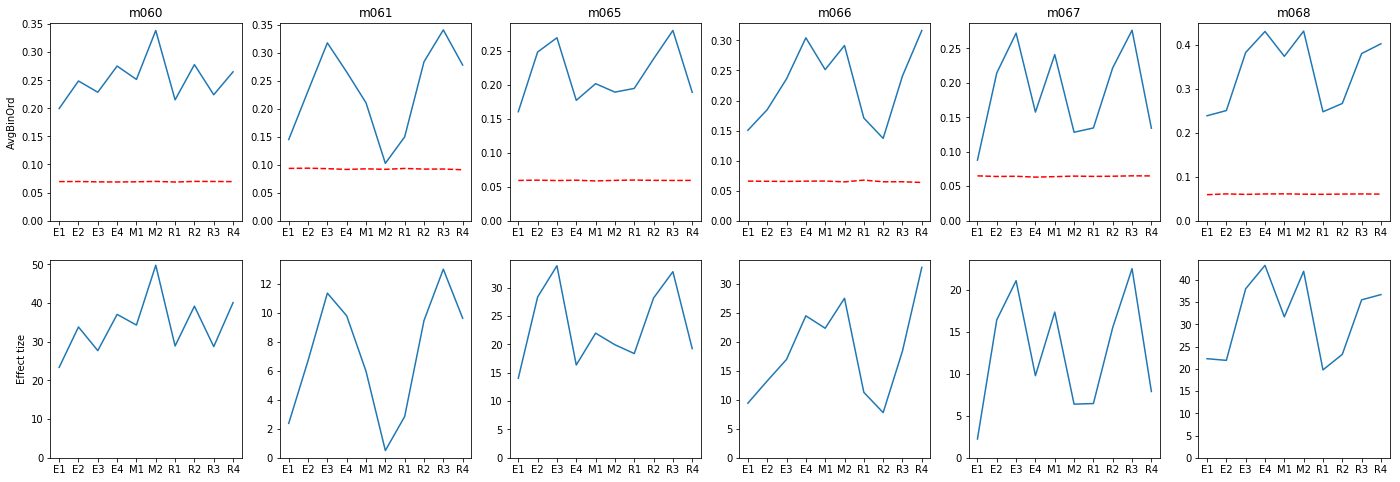

In [52]:
# test_average_orderability(dataDB, queryDict, signCellsMouseDict=None)

for datatype in ['raw', 'deconv']:
     for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
        test_average_orderability(dataDB, datatype, 'semiphase', 'Correct', signCellsSelector={signCellsName:signCells})